#Single-view and Multi-View geometry

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

Mounted at /content/drive


In [3]:
!pwd
%cd "notebooks/inverse graphics"

%ls
%cd "pytorch3d library"

/content
/content/drive/My Drive/Colab Notebooks/inverse graphics
'Copy of HW_1.ipynb'   hw2/   hw3/  'pytorch3d library'/
/content/drive/My Drive/Colab Notebooks/inverse graphics/pytorch3d library


## Setup

Below some setup we need for running everything on Colab. Feel free to skip this section.

### Imports

In [4]:
# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np

# To make code more readable: some helpful Python 3 type hints
from typing import Callable, List, Optional, Tuple

### Pytorch3D

In [5]:
import pytorch3d

Use this (my) version. Only need to be run once. 

In [6]:
%%script echo skipping
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.13.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

skipping


### Testing code




In [7]:
def check_function(test_name, function_name, test_input, test_output):
    try:
        student_output = function_name(*test_input)
    except TypeError as error:
        print("Function", test_name, "has a error and didn't run cleanly. Error:", error)
        return False
    if isinstance(student_output, tuple):
        student_output = list(student_output)
    else:
        student_output = [student_output]

    for i in range(len(test_output)):
        if not torch.allclose(student_output[i], test_output[i], rtol=1e-03):
            print(test_name, ": Your function DOES NOT work.")
            return False
    print(test_name, ": Your function works!")
    return True

In [8]:
import torch
print(f"Installed Torch version: {torch.__version__}")

Installed Torch version: 1.13.0+cu116


In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

cpu


# Part 1: Pointclouds, camera parameters, coordinate transformations, projections.

Working with a pointcloud to explore rigid-body transformations (rotations and translations), camera parameters, and projections.

## 1.0. Setup: Loading and plotting the vertices of a mesh as a pointcloud

We will use a 3D scan from 1993 of the [famous "Stanford bunny"](https://faculty.cc.gatech.edu/~turk/bunny/bunny.html) by Greg Turk as a testbed for the code you'll write. For this first part, we'll only use the vertices of the mesh, which make up a point cloud.

We download the mesh from [alecjacobson](http://www.cs.toronto.edu/~jacobson/)'s [`common-3d-test-models`](https://github.com/alecjacobson/common-3d-test-models) repository.

In [10]:
url = "https://raw.githubusercontent.com/alecjacobson/common-3d-test-models/master/data/stanford-bunny.obj"
!wget --quiet --show-progress --no-clobber {url}
!ls -l stanford-bunny.obj

-rw------- 1 root root 2408417 Dec 17 18:56 stanford-bunny.obj


We use pytorch3d to load the mesh, which allows us to get its vertices by calling `.get_mesh_verts_faces()`

In [11]:
from pytorch3d.io import load_objs_as_meshes, load_obj
mesh = load_objs_as_meshes(['stanford-bunny.obj'], device=device)
verts, _ = mesh.get_mesh_verts_faces(0)

/content/drive/My Drive/Colab Notebooks/inverse graphics/pytorch3d library/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


First, let's plot the point cloud using a matplotlib helper function:

In [12]:
def plot_pointcloud(
    vertices, 
    alpha=.5, 
    title=None, 
    max_points=10_000, 
    xlim=(-1, 1), 
    ylim=(-1, 1),
    zlim=(-1, 1)
    ):
    """Plot a pointcloud tensor of shape (N, coordinates)
    """
    vertices = vertices.cpu()

    assert len(vertices.shape) == 2
    N, dim = vertices.shape
    assert dim==2 or dim==3

    if N > max_points:
        vertices = np.random.default_rng().choice(vertices, max_points, replace=False) # vertcies.shape = N, dim 인데 dim 이 한 묶음. i.e, [[1,2],[4,5],...] 이런식. 따라서 N 개의 vertices 중에서 max_points vertices 만큼 choose
    fig = plt.figure(figsize=(6,6))
    if dim == 2:
        ax = fig.add_subplot(111)
    elif dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.set_zlabel("z")
        ax.set_zlim(zlim)
        ax.view_init(elev=120., azim=270)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.set_axis_off()

    ax.scatter(*vertices.T, alpha=alpha, marker=',', lw=.5, s=1, color='black') # each vertice dim can be either 2 or 3. # so scatter will plot each vertice and each row of vertices.T will be x=vertices[0],
    # y = vertices[0] and so on
    plt.show(fig)

In [14]:
pointcloud3D = verts
pointcloud2D = pointcloud3D[..., :2]
# we use "..." instead of ":" to indicate we just want index in the last dimension,
# not require pointcloud to be rank 2. This helps keep code flexibilty wrt. batch dimension

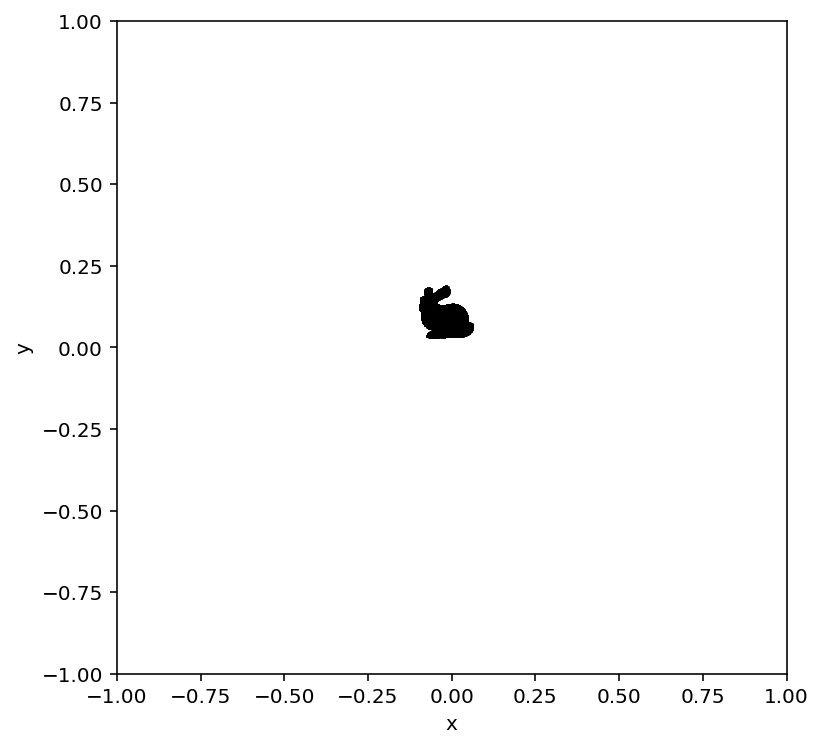

In [15]:
%matplotlib inline
plot_pointcloud(pointcloud2D)

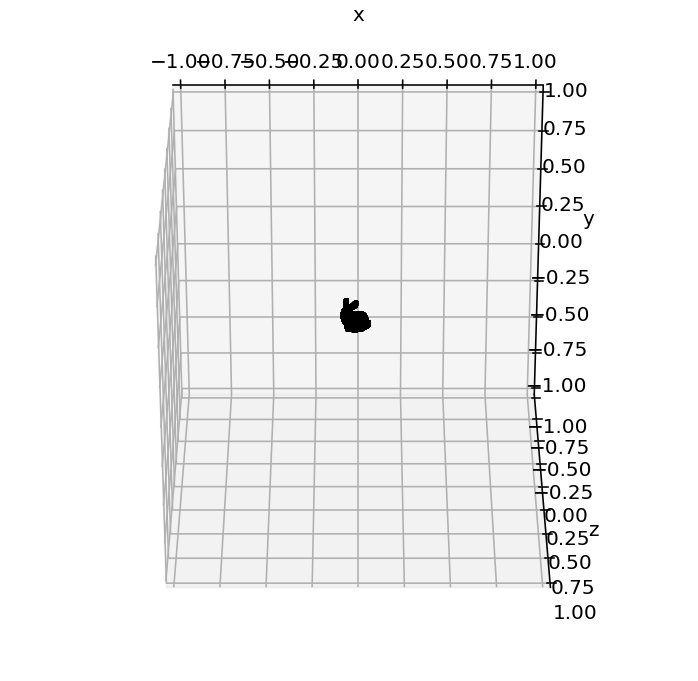

In [16]:
plot_pointcloud(pointcloud3D)# 120, 270

That's a bit small. Let's center the pointcloud by subtracting it's mean and rescaling it by it's max to make it lie in the unit cube:

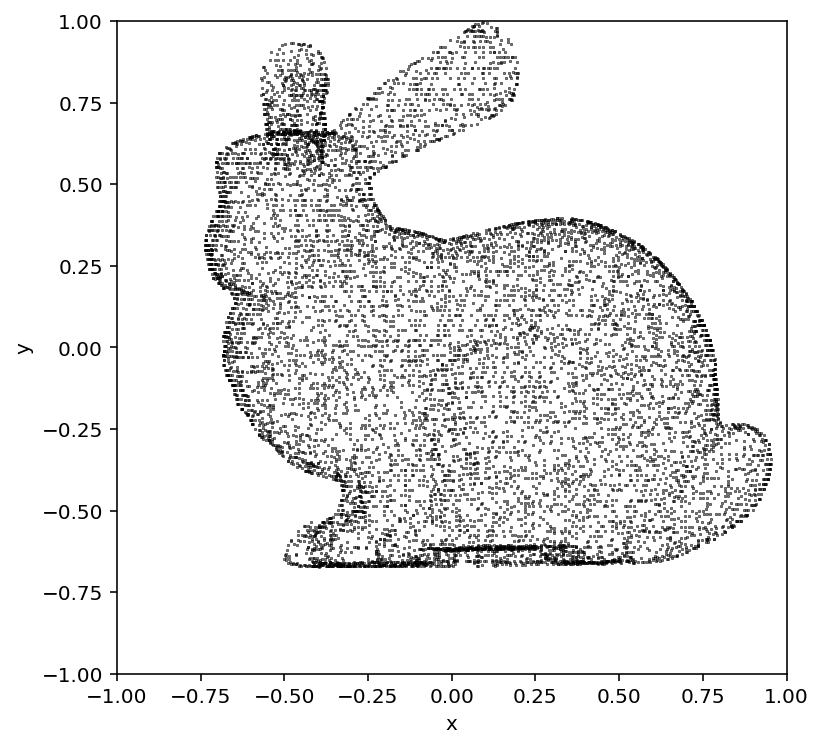

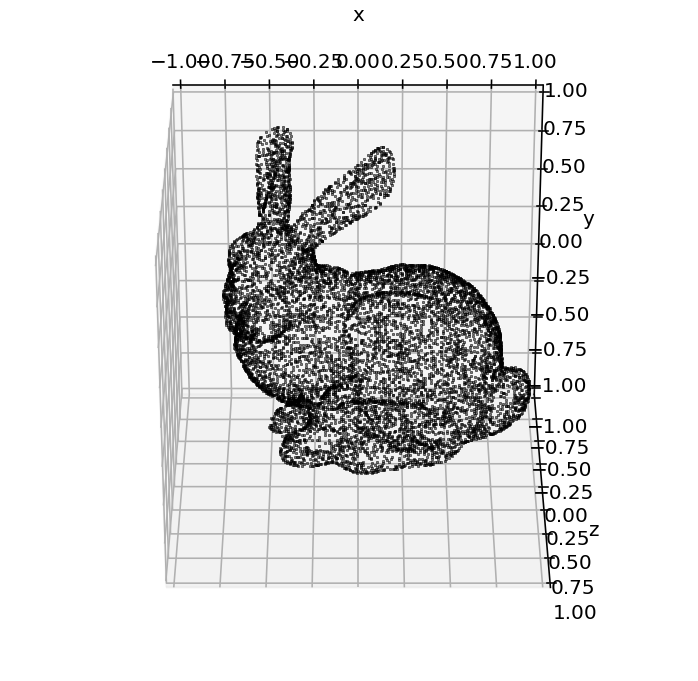

In [17]:
pointcloud3D -= pointcloud3D.mean(dim=0)
pointcloud3D /= pointcloud3D.max()
pointcloud2D = pointcloud3D[..., :2]

plot_pointcloud(pointcloud2D)
plot_pointcloud(pointcloud3D)

Better. We're ready to go!

## 1.2. Rigid-body transforms

Implement three functions: one to homogenize *points* (append a 1 to the coordinates), one to homogenize *vectors* (append a 0 to the coordinates), and one to apply a rigid-body transform to homogenized points / vectors. We recommend you use ```einsum``` for the latter.

In [20]:
def homogenize_points(points: torch.Tensor):
    """Appends a "1" to the coordinates of a (batch of) points of dimension DIM.

    Args:
        points: points of shape (..., DIM) DIM =3 when 3D, DIM = 2 when 2D

    Returns:
        points_hom: points with appended "1" dimension.
    """
    points_hom = torch.cat((points, torch.ones(size=(points.shape[0],1)).int()), dim=-1)
    # print(points_hom)
    return points_hom
    
check_function("homogenize_points", 
               homogenize_points, 
               [torch.tensor([[0, 0, 0]])], 
               [torch.tensor([[0, 0, 0, 1]])])

homogenize_points : Your function works!


True

In [21]:
def homogenize_vecs(vectors: torch.Tensor):
    """Appends a "0" to the coordinates of a (batch of) vectors of dimension DIM.

    Args:
        vectors: vectors of shape (..., DIM)

    Returns:
        vectors_vec: vectors with appended "0" dimension.
    """
    vectors_vec = torch.cat((vectors, torch.zeros(size=(vectors.shape[0],1))), dim=-1)
    return vectors_vec

check_function("homogenize_vecs", 
               homogenize_vecs, 
               [torch.zeros(1, 4)], 
               [torch.tensor([[0., 0, 0, 0, 0]])])

homogenize_vecs : Your function works!


True

In [22]:
def transform_rigid(xyz_hom: torch.Tensor, T: torch.Tensor) -> torch.Tensor:
    """Apply a rigid-body transform to a (batch of) points / vectors.

    Args:
        xyz_hom: homogenized 3D points of shape (..., 4)
        T: rigid-body transform matrix of shape (..., 4, 4) 각 포인트마다 각각의 T 가 있음?

    Returns:
        xyz_trans: transformed points *in homogeneous coordinates*.
    """
    xyz_trans = torch.einsum('bij,bj->bi', T, xyz_hom)
    # print(xyz_trans)
    return xyz_trans

check_function("transform_rigid",
               transform_rigid, 
               [torch.tensor([[0., 0, 0, 1]]),
                torch.tensor([[[0, 0, 0, 1.],
                              [0, 0, 0, 0],
                              [0, 0, 0, 0],
                              [0, 0, 0, 1]]])], 
               [torch.tensor([[1., 0, 0, 1.]])]) 

transform_rigid : Your function works!


True

Time for a test! Let's rotate the bunny by 90 degrees around the z-axis. The rigid-body transform for this is a matrix that simply swaps x and y coordinates.

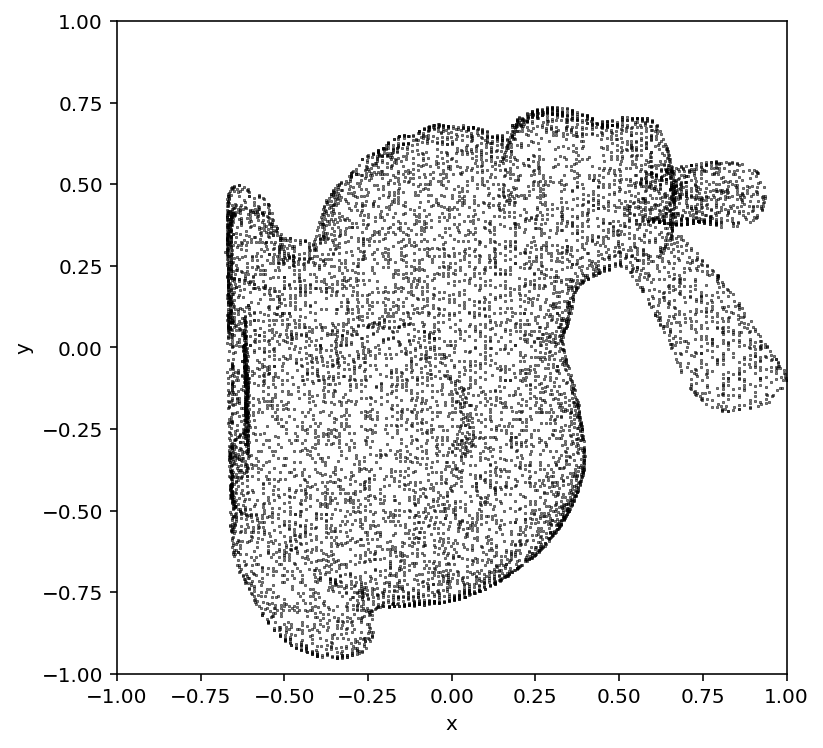

In [23]:
T = torch.tensor([[[0., 1., 0., 0.],
                  [-1., 0., 0., 0.],
                  [0., 0., 1., 0.],
                  [0., 0., 0., 1.]]], device=device) # added one more bracket []. original version is wrong

v_hom = homogenize_points(pointcloud3D)
v_prim = transform_rigid(v_hom, T)

plot_pointcloud(v_prim[:, :2])

## 1.3. Camera parameters and transforms

As discussed in the course, to model the image that a camera perceives of a given 3D scene (such as our pointcloud), we model a pinhole camera via two parameters: The extrinsic camera matrix and the intrinsic camera matrix.

The extrinsic camera matrix is simply the rigid-body transform that defines "where" the camera is relative to some world origin. By convention, we will always store this camera in the ```cam2world``` format, i.e., as a rigid-body transform that takes a point defined in camera coordinates to world coordinates. ```cam2world``` and ```world2cam``` transforms are inverses of each other!

For the whole rest of the course, we always assume the **OpenCV conventions** for camera coordinates. That means:

*   Image origin $(0, 0)$ is at top left corner 
*   y-axis points down
*   x-axis points right
*   z-axis points _into the image plane_, i.e., everything in front of the camera has positive z values (depths).

Next, we will write convenience functions to transform points and vectors from camera to world coordinates and vice-versa. 

Below, **implement the functions `transform_world2cam` and `transform_cam2world`**, to be called with homogenized 3D points/vectors, following the convention that all functions will always assume that they will be called with ```cam2world``` matrices.  Make use of the fact that the rigid-body transforms for world2cam and cam2world are inverses of each other, and use the rigid-body transform function you have written above.

To further understand the camera matrices, we suggest that you read this [3 part blog](https://ksimek.github.io/2012/08/14/decompose/) on this topic.

In [24]:
def transform_world2cam(xyz_world_hom: torch.Tensor, cam2world: torch.Tensor) -> torch.Tensor:
    """Transforms points from 3D world coordinates to 3D camera coordinates.

    Args:
        xyz_world_hom: homogenized 3D points of shape (..., 4)
        cam2world: camera pose of shape (..., 4, 4)

    Returns:
        xyz_cam: points in camera coordinates.
    """
    if cam2world.dim() == 2:
      world2cam = torch.inverse(cam2world) # world2cam
      xyz_cam = torch.einsum('ij, bj -> bi', world2cam, xyz_world_hom)
      return xyz_cam
    elif cam2world.dim() == 3:
      world2cam = torch.inverse(cam2world) # world2cam
      xyz_cam = torch.einsum('bij, bj -> bi', world2cam, xyz_world_hom)
      return xyz_cam

check_function("transform_world2cam", 
               transform_world2cam,
               [torch.tensor([[0., 0., 0., 1.]]),
                # torch.tensor([[1., 0., 0., 0.], 
                #             [0., 1., 0., 5.],
                #             [0., 0., 1., 0.],
                #             [0., 0., 0., 1.]])],
                torch.tensor([[[1., 0., 0., 0.], # added []
                            [0., 1., 0., 5.],
                            [0., 0., 1., 0.],
                            [0., 0., 0., 1.]]])],
               [torch.tensor([[0., -5., 0., 1]])])

transform_world2cam : Your function works!


True

In [25]:
def transform_cam2world(xyz_cam_hom: torch.Tensor, cam2world: torch.Tensor) -> torch.Tensor:
    """Transforms points from 3D world coordinates to 3D camera coordinates.

    Args:
        xyz_cam_hom: homogenized 3D points of shape (..., 4)
        cam2world: camera pose of shape (..., 4, 4)

    Returns:
        xyz_world: points in camera coordinates.
    """
    if cam2world.dim() == 3:
      xyz_world = torch.einsum('bij, bj -> bi', cam2world, xyz_cam_hom)
      return xyz_world
    elif cam2world.dim() == 2:
      xyz_world = torch.einsum('ij, bj -> bi', cam2world, xyz_cam_hom)
      return xyz_world
check_function("transform_cam2world", 
               transform_cam2world,
               [torch.tensor([[0., 0., 0., 1.]]),
              #   torch.tensor([[1., 0., 0., 0.],
              #               [0., 1., 0., 5.],
              #               [0., 0., 1., 0.],
              #               [0., 0., 0., 1.]])],
                torch.tensor([[[1., 0., 0., 0.],
                            [0., 1., 0., 5.],
                            [0., 0., 1., 0.],
                            [0., 0., 0., 1.]]])],
               [torch.tensor([[0., 5., 0., 1]])])

transform_cam2world : Your function works!


True

Implement the function "project" that takes a homogeneous 3D point in camera coordinates as well as camera intrinsics and projects them onto the image plane to return homogeneous points in pixel coordinates.

In [26]:
def project(xyz_cam_hom: torch.Tensor, intrinsics: torch.Tensor) -> torch.Tensor:
    """Projects homogenized 3D points xyz_cam_hom in camera coordinates 
    to pixel coordinates.

    Args:
        xyz_cam_hom: 3D points of shape (..., 4)
        intrinsics: camera intrinscics of shape (..., 3, 3)

    Returns:
        xy: homogeneous pixel coordinates of shape (..., 3) (final coordinate is 1)
    """    


    if intrinsics.dim() == 3: # intrinsics has batch of matrices
      # add a col of zeros to matrices in intrisics
      batch = intrinsics.shape[0]
      rows = intrinsics.shape[1]
      cols = intrinsics.shape[2]
      intrinsics = intrinsics.reshape(batch * rows,  cols)
      intrinsics = torch.cat((intrinsics, torch.zeros(size=(batch*rows,1))), dim=-1).reshape(batch,rows,-1)

      xy = torch.einsum('bij, bj -> bi', intrinsics, xyz_cam_hom)
      z_values = xy[:, -1]
      xy_div = xy / z_values.reshape(-1,1)
    elif intrinsics.dim() == 2: # intrinsics has one matrix
      # add a col of zeros
      # print(torch.zeros(size=(intrinsics.shape[0],1)).shape)
      # print(intrinsics.shape)
      intrinsics = torch.cat((intrinsics, torch.zeros(size=(intrinsics.shape[0],1))),dim=-1)

      xy = torch.einsum('ij, bj -> bi', intrinsics, xyz_cam_hom)
      # divide each position by its z value respectively
      # print(xy.shape)
      # xy /=  xy[-1]
      # print(xy.shape)
      z_values = xy[:, -1]
      # print(z_values.shape)
      xy_div = xy / z_values.reshape(-1,1)
      
    return xy_div

check_function("project", project,
               [torch.tensor([[0., 0., 5, 1]]),
                torch.tensor([[32., 0, 64],
                            [0, 32, 64],
                            [0, 0, 1]])],
               [torch.tensor([64., 64., 1.])])

project : Your function works!


True

## 1.4. A very simple pointcloud occupancy renderer



In [27]:
img_resolution = (256, 256)

test_cam2world_cv = torch.tensor([[1., 0., 0., 0.],
                                  [0., -1., 0., 0.],
                                  [0., 0., -1., 3.], # 여기 3인 이유는, camera space 에서 (0,0,0) 이지만 world space에서 camera 는 (0,0,3) 이니까 camera space 에있던 다른 points 들도 z 로 3만큼 이동
                                  [0., 0., 0., 1.]], device=device)
test_K_cv  = torch.tensor([[0.5, 0., 0.5],
                            [0., 0.5, 0.5],
                            [0., 0.,  1.]], device=device)

We will now project the points onto the camera image plane and do a scatterplot of that!

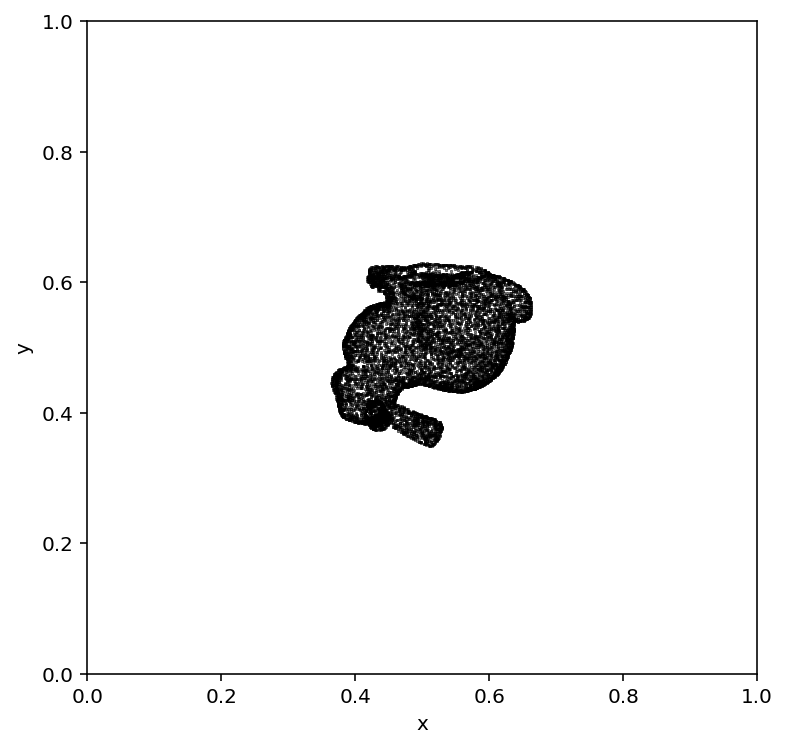

In [28]:
v_hom = homogenize_points(verts)

xyz_cam_hom = transform_world2cam(v_hom, test_cam2world_cv)
xy_pix_hom = project(xyz_cam_hom, test_K_cv)
plot_pointcloud(xy_pix_hom[..., :2], xlim=(0, 1), ylim=(0, 1))

We note a few things:

1.   The bunny is on its head. 
2.   This is a scatterplot of the *continuous coordinates* of projected points, while an image is usually discretized into a grid of pixels.
3.   Note that the origin $(0, 0)$ of this plot is at the _bottom left_! This is different from the OpenCV camera coordinate system that we assumed, where the origin is at the _top left_!

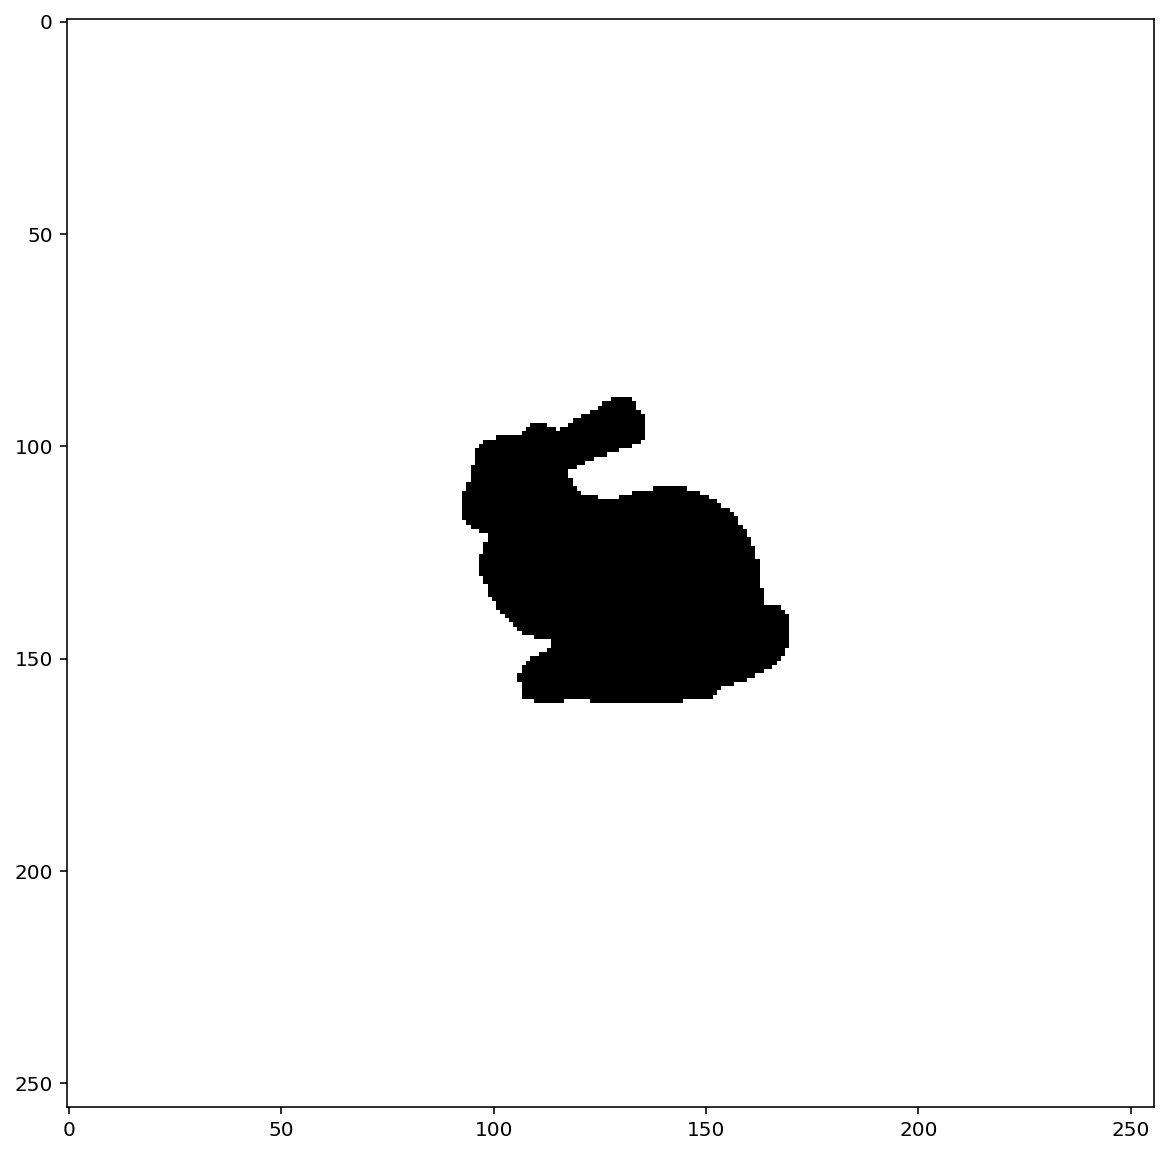

In [29]:
def discretize_normalized_2d_pointcloud_to_img(
    pointcloud_2d, # pointcloud_2d.shape = (N , 2)
    img_resolution = (100, 100)
):
    img = np.zeros(img_resolution)
    x, y = np.split(pointcloud_2d, 2, axis=-1)  # x.shape = (N, 1), i.e, x coordinates of all samples. x, y are in [0,1]
    x_ = x.clone()
    y_ = y.clone()

    x_ *= img_resolution[0] # apply 100 to every sample's x coordinate? yes, because original x,y are in [0,1]. We want to map them to an image of size (100,100)
    y_ *= img_resolution[1]
    
    x_, y_ = x_.int(), y_.int()
    img[y_,x_] = 1. 
    # img[x_,y_] = 1.

    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='Greys')
    # plt.axis("off");
    plt.show()

discretize_normalized_2d_pointcloud_to_img(xy_pix_hom.cpu()[..., :2], # :2 is to account for only x and y coordinates
                                          img_resolution=img_resolution)

In [30]:
def render_pointcloud(
    pointcloud: torch.Tensor, # N * D  where D == 3 usually because 3d coordinate
    cam2world: torch.Tensor,
    intrinsics: torch.Tensor, # camera parameters such as focal length, p_x, p_y
    img_resolution = (100, 100)
):
    xyz_cam_hom = transform_world2cam(pointcloud, cam2world) # use inverse(cam2world) in the function
    xy_pix_hom = project(xyz_cam_hom, intrinsics)
    img = discretize_normalized_2d_pointcloud_to_img(xy_pix_hom.cpu()[..., :2], img_resolution)
    return img

## 1.5. Rendering meshes with Pytorch3D renderer, camera conventions


### 1.5.0 Setup

In [31]:
# Data structures and functions for rendering
import pytorch3d
from pytorch3d.structures import Meshes
import pytorch3d.utils
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    FoVPerspectiveCameras, 
    PointLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader,
    TexturesUV,
    TexturesVertex,
    Textures
)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=img_resolution, 
    bin_size=None,
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

lights = PointLights(device=device, location=[[-2.0, -2.0, -5.0]])

materials = Materials(
    device=device,
    specular_color=[[0.0, 0.0, 0.0]],
    shininess=0.0
)

rasterizer=MeshRasterizer(raster_settings=raster_settings)

# Set up a renderer.
renderer = MeshRenderer(
    rasterizer=rasterizer, # calculate which pixels are covered by which mesh?
    shader=HardPhongShader(device=device, lights=lights) # similar with fragment shader?
)

First, download a mesh version of the Stanford bunny. The code below, you don't have to investigate closely - it's just Pytorch3D's API for loading meshes, assigning textures etc.

In [32]:
mesh = load_objs_as_meshes(['stanford-bunny.obj'], device=device)
verts, faces = mesh.get_mesh_verts_faces(0)
texture_rgb = torch.ones_like(verts, device=device) 
texture_rgb[:, 1:] *= 0.0  # red, by zeroing G and B
mesh.textures = Textures(verts_rgb=texture_rgb[None])

Again, we center and re-scale the vertices...

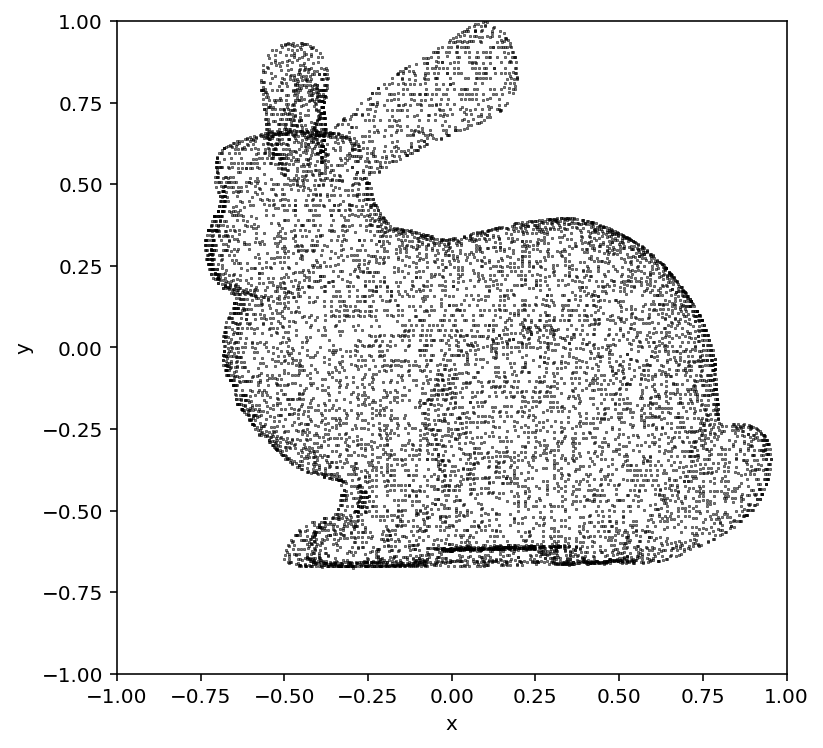

In [33]:
verts = verts - verts.mean(dim=0)
verts /= verts.max()

# This updates the pytorch3d mesh with the new vertex coordinates.
mesh = mesh.update_padded(verts.unsqueeze(0)) 
verts, faces = mesh.get_mesh_verts_faces(0)

plot_pointcloud(verts[..., :2]) # plot only x,y coordinates

### 1.5.1 Reproduce point cloud renderings

In [34]:
def pytorch3d_image_formation():
    # Fill below
    # Does Pytorch3D use a cam2world or world2cam convention when talking about camera poses (see "Defining Cameras in PyTorch3D")?
    cam2world_or_world2cam = 'world2cam' # delete the incorrect answer.
    
    # Where do the axes of the camera point? (see "Interfacing with the PyTorch3D Renderer")
    x = 'left'
    y = 'up'
    z = 'out of image'
    # raise NotImplementedError("Not yet implemented.")
    return cam2world_or_world2cam, x, y, z


We'll use Pytorch3D's `PerspectiveCameras` to define a camera for the renderer to ingest. Take a look at the API [here](https://pytorch3d.readthedocs.io/en/latest/modules/renderer/cameras.html#pytorch3d.renderer.cameras.PerspectiveCameras).

In other words, we'll have to pass in a rotation matrix R, a translation tvec,
a camera_matrix / intrinsics K. However, we'll have to pass them in in the Pytorch3D convention!

We'll spare you from actually converting these matrices yourself. Instead, we'll
use Pytorch3D's convenience function to convert from OpenCV (our format) to the Pytorch3D format.

In [35]:
test_world2cam_cv = torch.inverse(test_cam2world_cv)
cam = pytorch3d.utils.cameras_from_opencv_projection(R=test_world2cam_cv[:3, :3].unsqueeze(0), # unsqueeze is for a batch of matrices? # :3,:3 is rotation part from 4*4 extrinsic matrix
                                                     tvec=test_world2cam_cv[:3, -1].unsqueeze(0), # translation vector from 4*4 extrinsic matrix
                                                     camera_matrix=test_K_cv.unsqueeze(0), # intrinsic
                                                     image_size=torch.tensor([1., 1.], device=device).unsqueeze(0))

Using this cam object, we can now render our bunny:

tensor(0.5000) tensor(0.) tensor(0.)


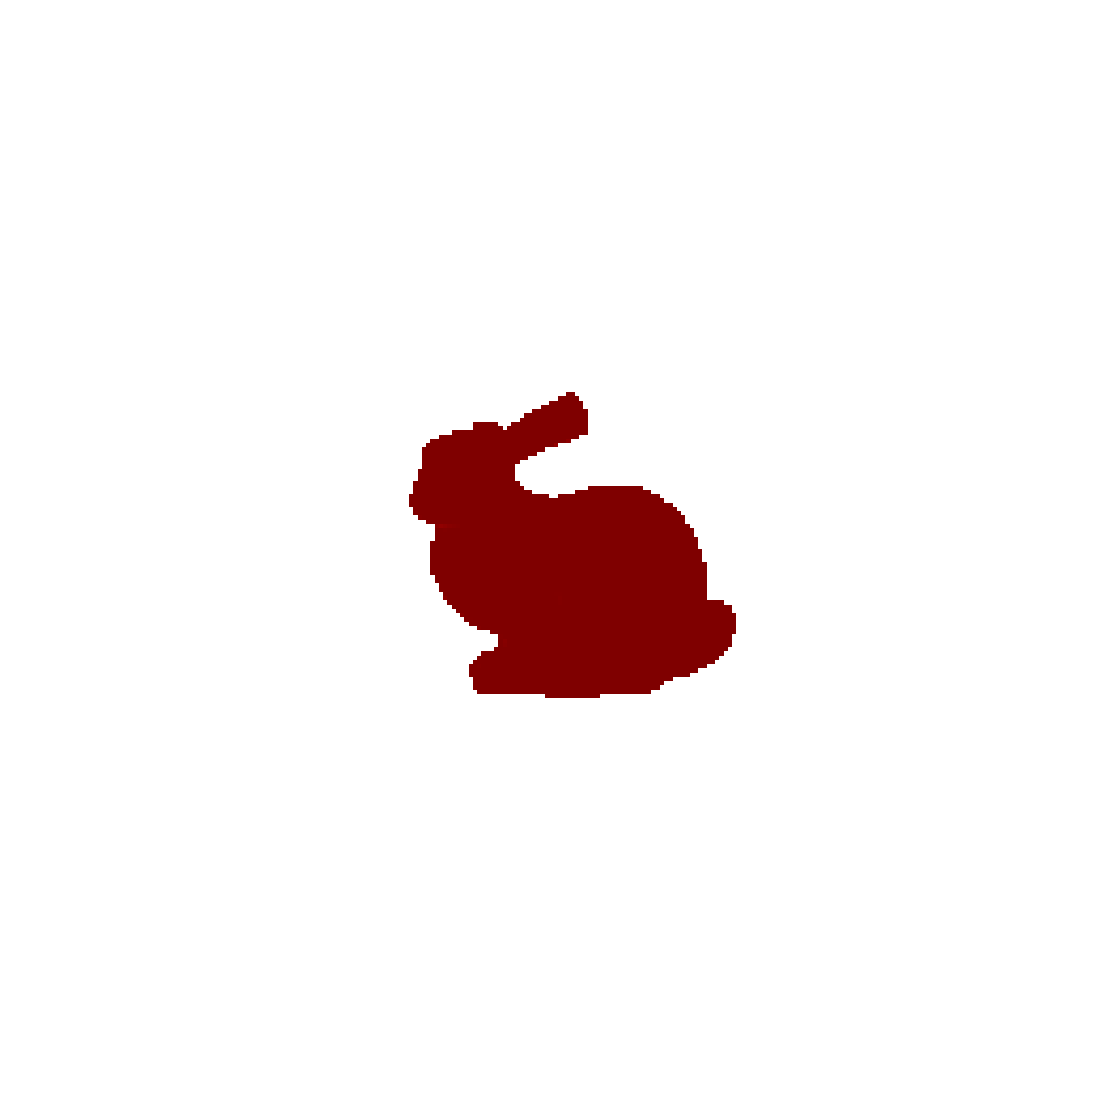

In [36]:
images = renderer(mesh, cameras=cam, lights=lights, materials=materials)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");
print(images[0,128,128,0], images[0,128,128,1], images[0,128,128,2])

## 1.6: 360-degree rendering the bunny

In [37]:
def generate_camera_locations(center: torch.Tensor, radius: float, num_points: int) -> torch.Tensor:
    """ Generate camera locations on the circumference of a circle along the 
        xz-plane.

    Args:
        center: location of the center of the circle of shape (3,). 
                We need to sample points on the circumference of the circle. 
        radius: radius of the circle.
        num_points: number of points
    Returns:
        camera_locations: location of the cameras of shape (num_points, 3)
    """
    # Write your code here and remove the raise command below.
    # raise NotImplementedError("Not yet implemented.")
    angles = np.linspace(0, 360.0, num_points)
    print(angles)
    def generate_rot_about_z(angle):
        angle = 2*np.pi / 360.0 * angle
        rot_matrix = torch.tensor([[np.cos(angle),   0,      np.sin(angle)],
                                  [0,                  1,      0],
                                  [-np.sin(angle),  0,      np.cos(angle)]])
        return rot_matrix

    start_pos = np.array([0,0,0.])
    start_pos[-1] = radius
    # list(map(generate_rot_about_z, angles))
    l = list(map(generate_rot_about_z, angles)) # list of tensors 
    # print(l)
    camera_locations =  torch.tensor([(mat @ start_pos.T).tolist() for mat in l]).reshape(-1,3).float()
    print(camera_locations)
    return camera_locations
    
check_function("generate_camera_locations",
               generate_camera_locations,
               [torch.tensor([0., 0., 0.], device=device), 3, 5],
               [torch.tensor([[ 0.0000e+00,  0.0000e+00,  3.0000e+00],
                    [ 3.0000e+00,  0.0000e+00, -1.3113e-07],
                    [-2.6227e-07,  0.0000e+00, -3.0000e+00],
                    [-3.0000e+00,  0.0000e+00,  3.5775e-08],
                    [ 5.2454e-07,  0.0000e+00,  3.0000e+00]], device=device)])

[  0.  90. 180. 270. 360.]
tensor([[ 0.0000e+00,  0.0000e+00,  3.0000e+00],
        [ 3.0000e+00,  0.0000e+00,  1.8370e-16],
        [ 3.6739e-16,  0.0000e+00, -3.0000e+00],
        [-3.0000e+00,  0.0000e+00, -5.5109e-16],
        [-7.3479e-16,  0.0000e+00,  3.0000e+00]])
generate_camera_locations : Your function DOES NOT work.


False

[  0.           3.63636364   7.27272727  10.90909091  14.54545455
  18.18181818  21.81818182  25.45454545  29.09090909  32.72727273
  36.36363636  40.          43.63636364  47.27272727  50.90909091
  54.54545455  58.18181818  61.81818182  65.45454545  69.09090909
  72.72727273  76.36363636  80.          83.63636364  87.27272727
  90.90909091  94.54545455  98.18181818 101.81818182 105.45454545
 109.09090909 112.72727273 116.36363636 120.         123.63636364
 127.27272727 130.90909091 134.54545455 138.18181818 141.81818182
 145.45454545 149.09090909 152.72727273 156.36363636 160.
 163.63636364 167.27272727 170.90909091 174.54545455 178.18181818
 181.81818182 185.45454545 189.09090909 192.72727273 196.36363636
 200.         203.63636364 207.27272727 210.90909091 214.54545455
 218.18181818 221.81818182 225.45454545 229.09090909 232.72727273
 236.36363636 240.         243.63636364 247.27272727 250.90909091
 254.54545455 258.18181818 261.81818182 265.45454545 269.09090909
 272.72727273 276.

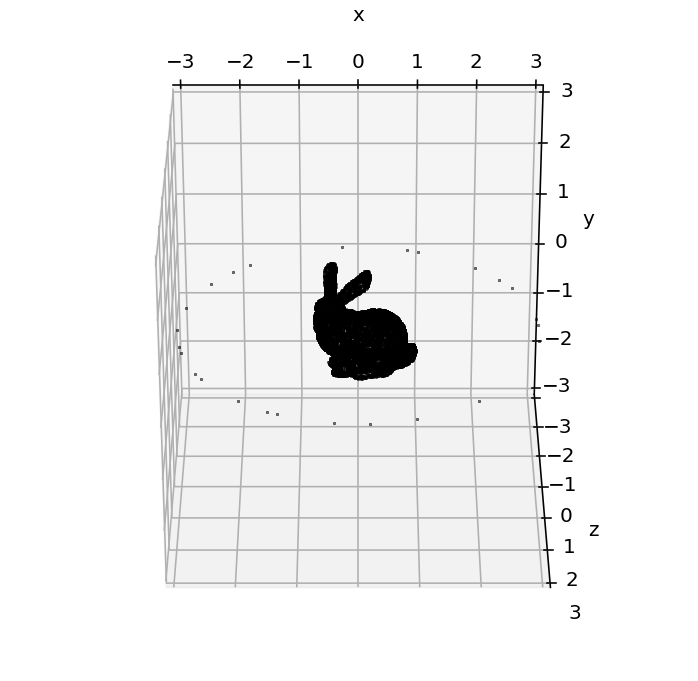

In [38]:
points = generate_camera_locations(torch.tensor([0., 0., 0.], device=device), 3, 100) # change 100 accordingly when running "images = renderer(mesh.extend(5), cameras=cams, lights=lights)"
plot_pointcloud(torch.cat((points, verts), dim=0), xlim=(-3, 3), ylim=(-3, 3), zlim=(-3, 3))

Great - this yields the camera translations in world coordinates. We now have to translate these into world2cam camera poses that Pytorch3D can ingest.

For that, we'll use the convenience function ```pytorch3d.renderer.look_at_view_transform```, documented [here](https://pytorch3d.readthedocs.io/en/latest/modules/renderer/cameras.html#pytorch3d.renderer.cameras.look_at_view_transform). This function takes as input two parameters: batches of 3D points "at" and "eye", where "eye" is the position of the camera center, and "at" is the point the camera should look at.

This function will then return a batch of world2cam R and T for a camera that looks from "eye" translation at the "at" point.

Below, use that convenience function to convert the camera poses.

In [47]:
def get_look_at_views(points: torch.Tensor, look_at_points: torch.Tensor):
    """ Compute the world2cam rotation 'R' and translation 'T' using the camera 
        locations 'points' and the look_at_points. Use the look_at_view_transform
        to get the R and T.

    Args:
        points: location of the cameras of shape (..., 3)
        look_at_points: location where the cameras are pointed at of shape (..., 3)
    Returns:
        R: rotation matrix for the world2cam matrix
        T: translation for the world2cam matrix
    """
    R, T = pytorch3d.renderer.look_at_view_transform(eye=points, at=look_at_points)
    return R, T
    
R_pt3d, T_pt3d = get_look_at_views(points, torch.zeros_like(points))

# points_0_80 = []
# points_0_80.append(points[0].tolist())
# points_0_80.append(points[80].tolist())
# points_0_80 = torch.tensor(points_0_80)
# R_pt3d, T_pt3d = get_look_at_views(points_0_80, torch.zeros_like(points_0_80))

check_function("get_look_at_views",
                get_look_at_views,
               [torch.tensor([[1., 0., 0.]], device=device), 
                torch.tensor([[0., 0., 0.]], device=device)],
               [torch.tensor([[[ 0.,  0., -1.],
                              [-0.,  1.,  0.],
                              [ 1.,  0.,  0.]]], device=device), 
                torch.tensor([[-0., -0., 1.]], device=device)])

get_look_at_views : Your function works!


True

There is one more catch: Pytorch3D has its own standards for the intrinsics matrix $\mathbf{K}$. Pt3D's matrix is in fact a 4x4 matrix, for reasons we won't bother you with - if you're curious, take a closer look at the pytorch3d camera conventions we linked above!

Here, simply find a fitting one below. 

In [40]:
K_pt3d = torch.tensor([[0.7, 0., 0.5, 0.],
                        [0., 0.7, 0.5, 0.],
                        [0., 0., 0., 1.0],
                        [0., 0., 1., 0.]], device=device)

We can now use $\mathbf{R}_{pt3d}$, $\mathbf{T}_{pt3d}$ and $\mathbf{K}_{pt3d}$ to generate Pytorch3D Perspective Cameras, documented [here](https://pytorch3d.readthedocs.io/en/latest/modules/renderer/cameras.html#pytorch3d.renderer.cameras.PerspectiveCameras).

In [48]:
cams = pytorch3d.renderer.cameras.PerspectiveCameras(R=R_pt3d, T=T_pt3d, K=K_pt3d.unsqueeze(0), 
                                                     in_ndc=False, image_size=[(1, 1)],
                                                     device=device)

Time to render!

This is my version1. Original version is the next next cell.

In [ ]:
images = renderer(mesh.extend(100), cameras=cams, lights=lights)
# images = renderer(mesh.extend(2), cameras=cams, lights=lights)

for i in range(len(images)):
    plt.imshow(images[i].cpu())
    plt.axis("off");
    plt.show()

This is my version2. Original version is the next cell. cams has only 5 cameras. So it will render 5 images.

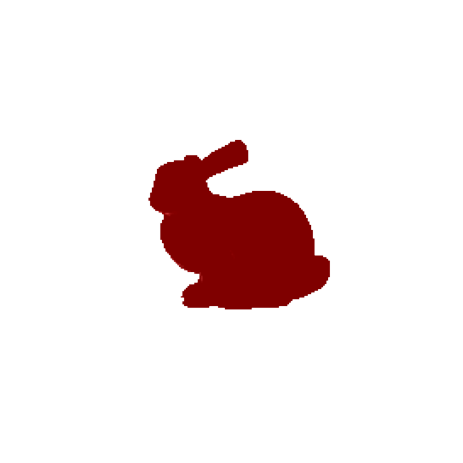

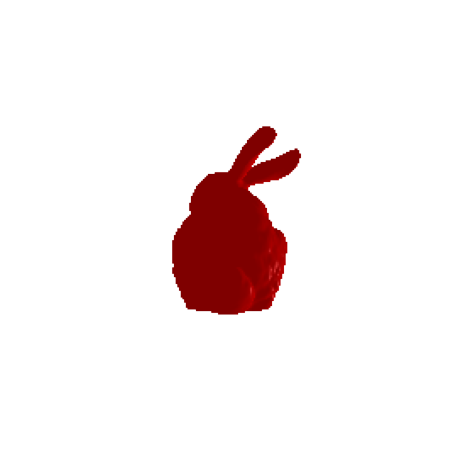

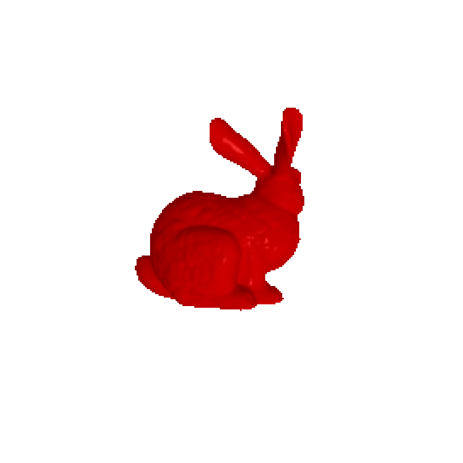

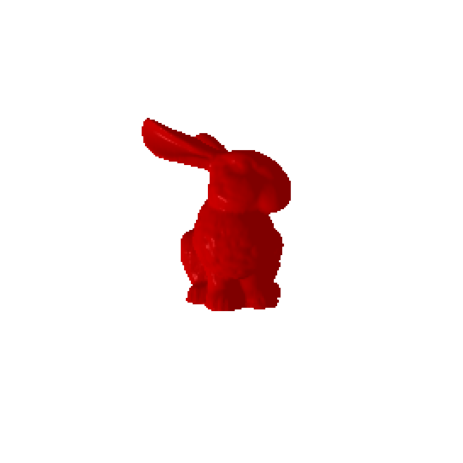

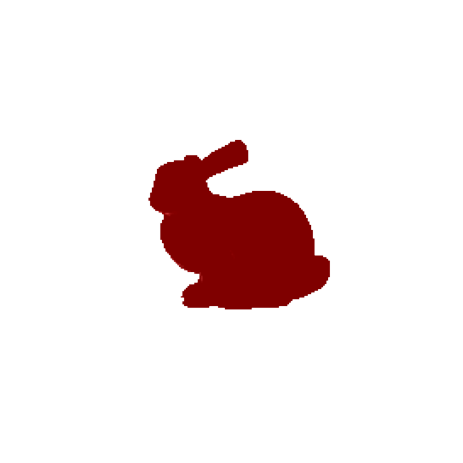

In [ ]:
images = renderer(mesh.extend(5), cameras=cams, lights=lights)

for i in range(len(images)):
    plt.imshow(images[i].cpu())
    plt.axis("off");
    plt.show()

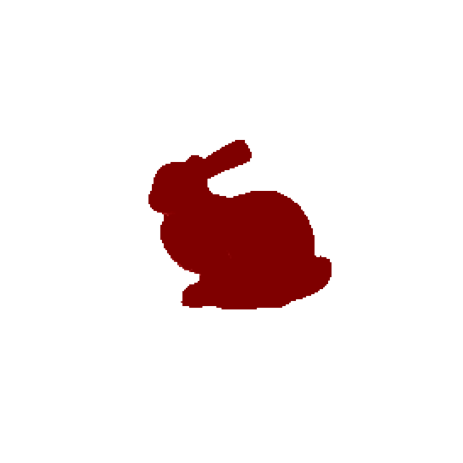

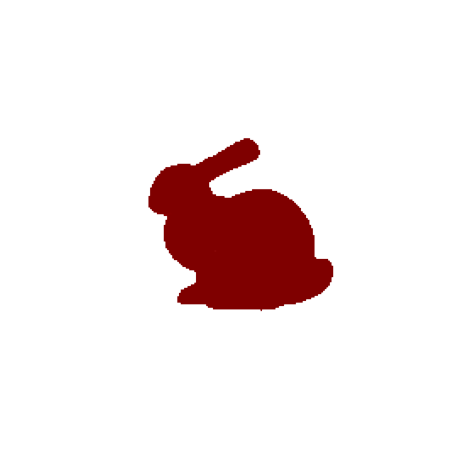

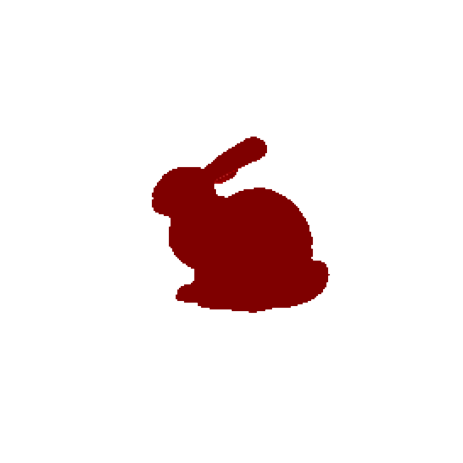

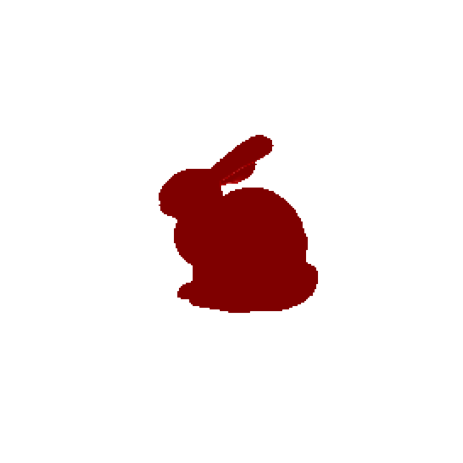

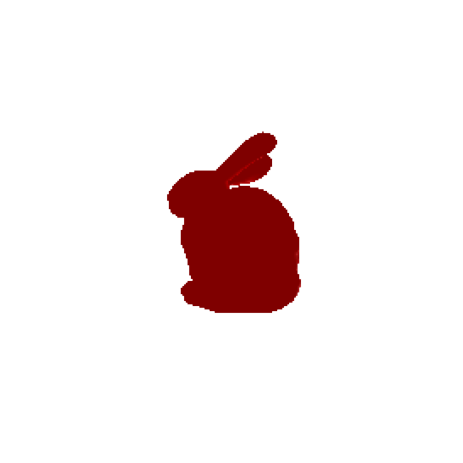

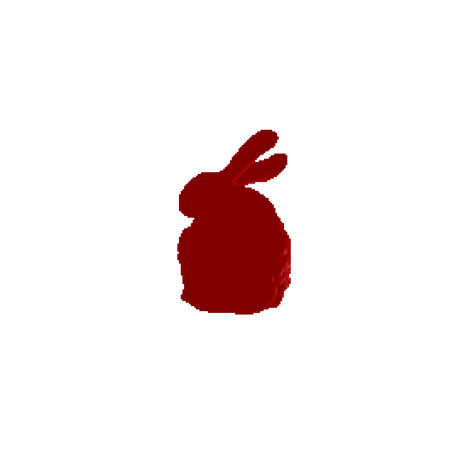

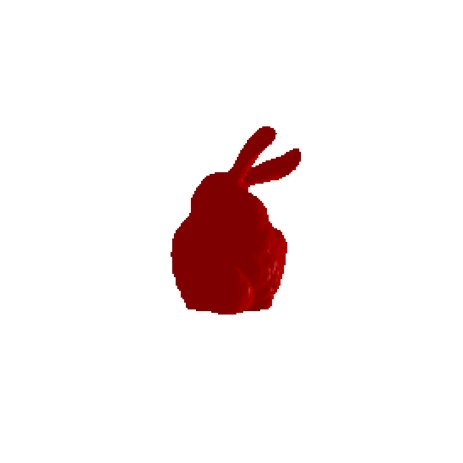

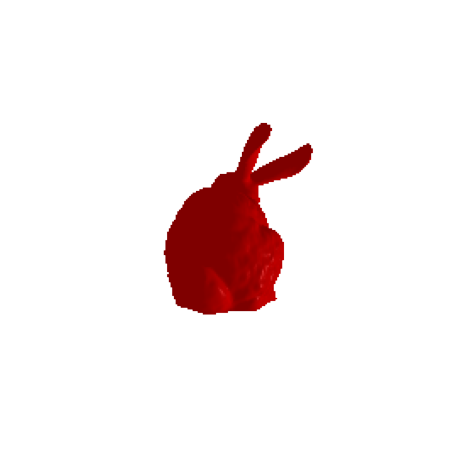

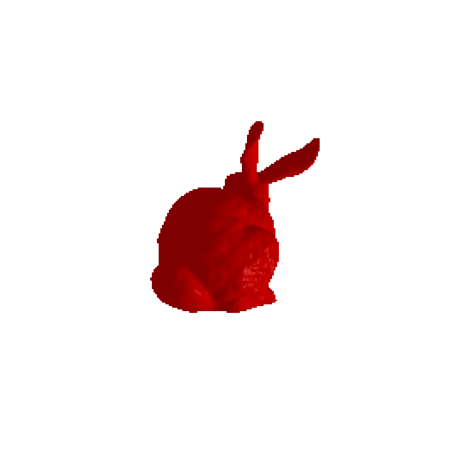

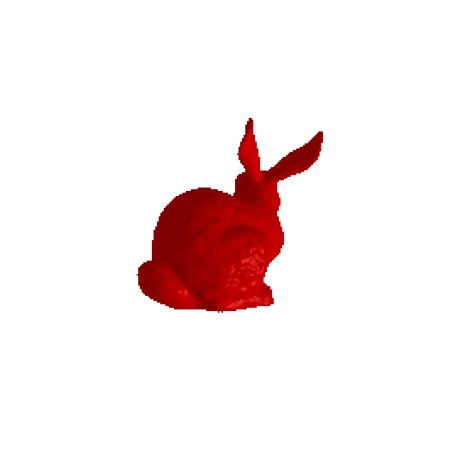

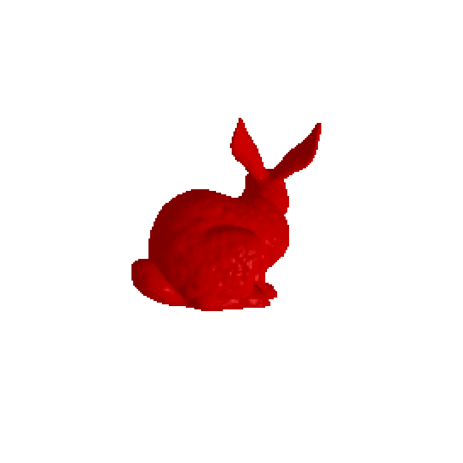

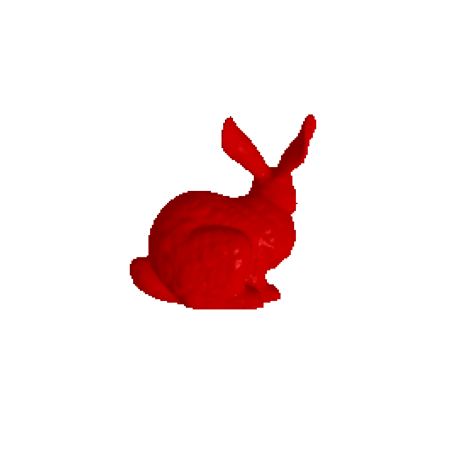

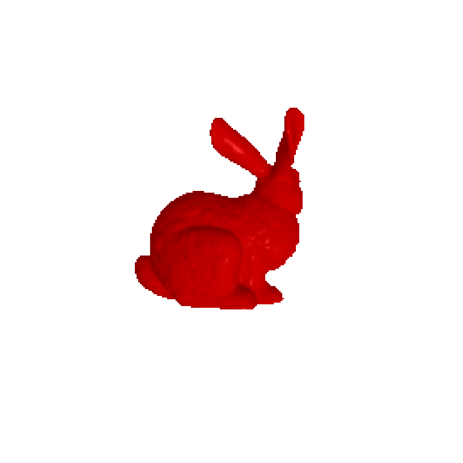

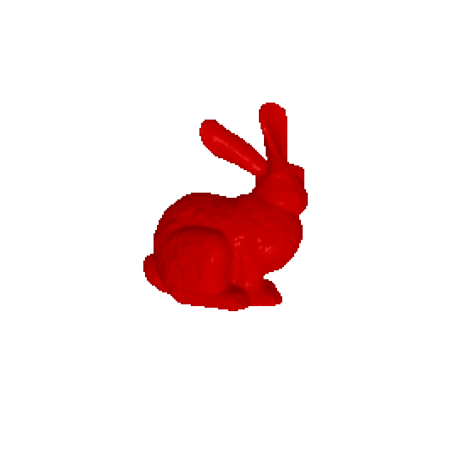

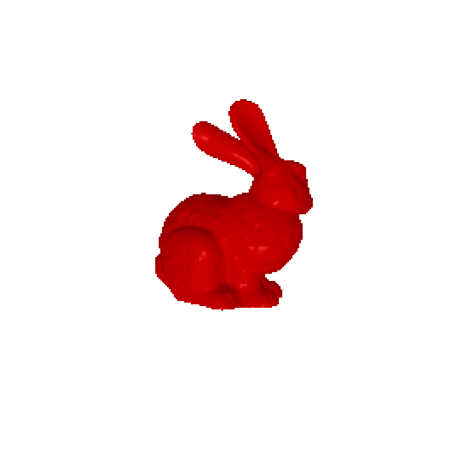

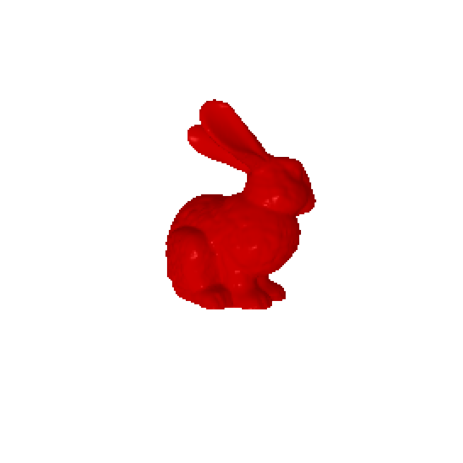

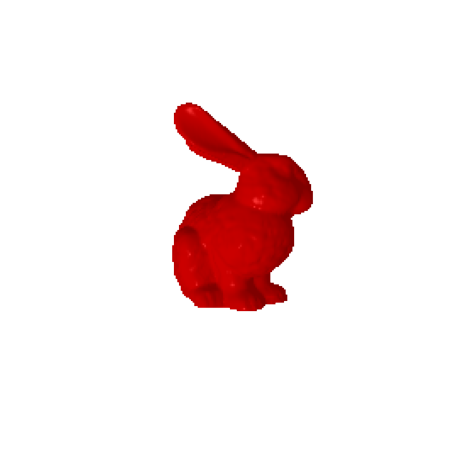

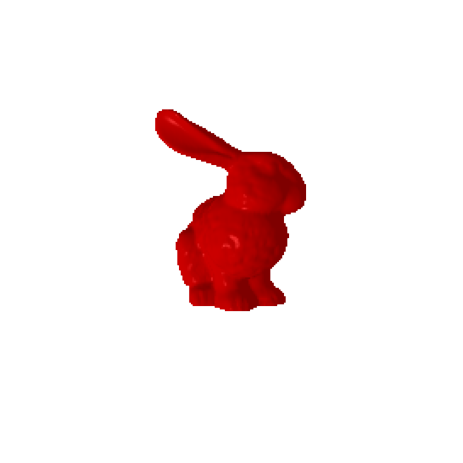

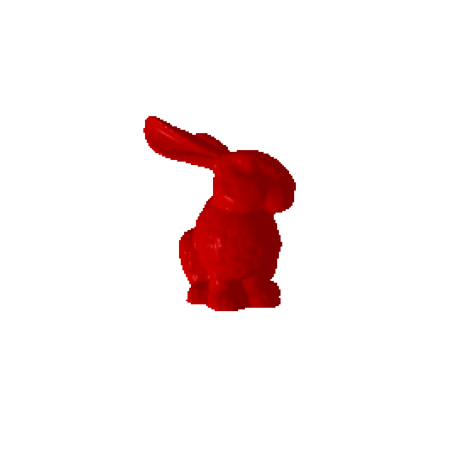

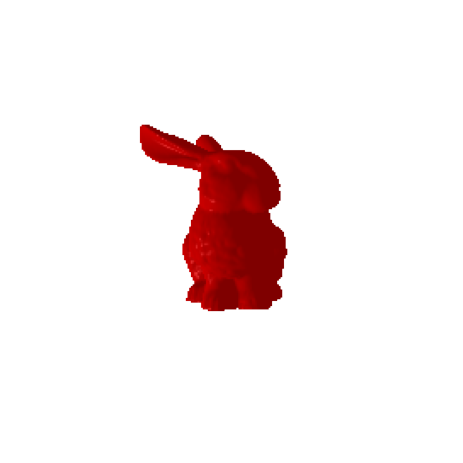

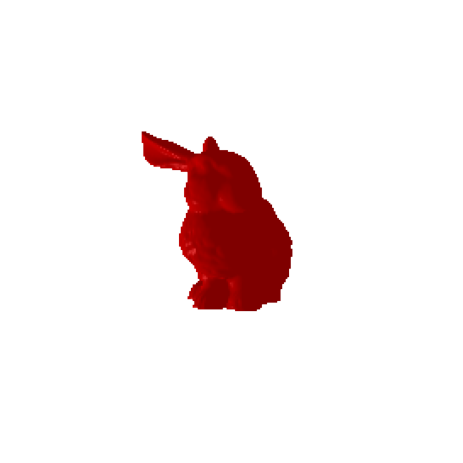

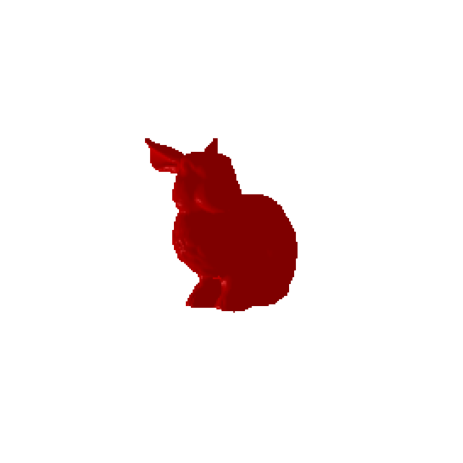

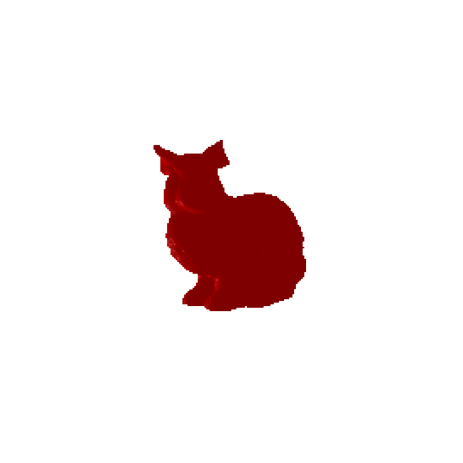

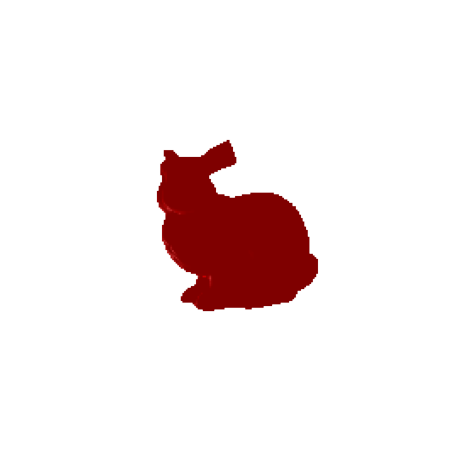

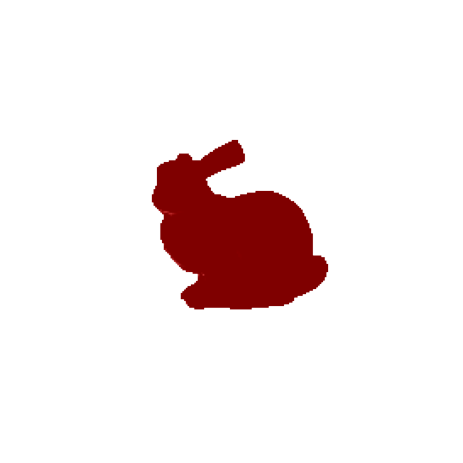

In [ ]:
images = renderer(mesh.extend(100), cameras=cams, lights=lights)

for i in range(1, len(images), 4):
    plt.imshow(images[i].cpu())
    plt.axis("off");
    plt.show()

## 1.7 Using Pytorch3D to generate a dataset in OpenCV convention


In [42]:
def pytorch3d_world2cam_to_opencv_world2cam(pytorch3d_cam):
    """ Convert the pytorch3d camera poses to opencv. # 이건 extrinsic part. 다음 cell 이 intrinsic

    Args:
        pytorch3d_cam: pytorch3d cameras. Please look at
                       pytorch3d_cam.R for the rotation, 
                       pytorch3d_cam.T for the translation vectors
    Returns:
        R_cv: rotation matrix for the world2cam matrix in OpenCV convention
        t_cv: translation for the world2cam matrix in OpenCV convention
    """
    R_pt3d = pytorch3d_cam.R
    t_pt3d = pytorch3d_cam.T

    R_cv = R_pt3d.clone()

    # Flip the x and the y axis.
    R_cv[:, :, :2] *= -1 # batch size, rows of matrix, cols of matrix
    
    # This is confusing - seemingly, this would turn the world2cam rotation matrix
    # into a cam2world rotation matrix (tranposing inverts rotation matrices)...?
    # It turns out that pytorch3d transforms vectors by *right-multiplying* with 
    # the camera pose, while OpenCV left-multiplies, so we need to transpose...
    # 즉, https://github.com/facebookresearch/pytorch3d/blob/main/pytorch3d/transforms/transform3d.py 에서 right-multiplied 검색해보면, M 이 row order 로 돼있음. v.T @ M.T 하는꼴. 따라서 
    # opencv 에서는 M @ v .  왜냐면 (v.T @ M.T).T = M @ v.  물론 여기서 M은 이미 x and y 가 flip 된 후.
    R_cv = R_cv.permute(0, 2, 1)

    t_cv = t_pt3d.clone()
    
    # Flip x and y axis.
    t_cv[:, :2] *= -1
    return R_cv, t_cv

Again, we'll spare you from converting the intrinsics parameters:

In [43]:
def K_pt3d_to_opencv(pytorch3d_cam):
    """
    pytorch3d_cam: pytorch3d cameras. Please look at
                pytorch3d_cam.K for the pytorch3d intrinsics.

    Returns:
        K_cv: intrinsic matrix in OpenCV conventions
    """
    K_pt3d = pytorch3d_cam.K
    K_cv = K_pt3d[:, :3, :3].clone() # remember pytorch 3d has its own version of K which is of size 4*4. We need only 3*3
    K_cv[:, -1, -1] = 1
    return K_cv

In [44]:
R_w2c_cv, tvec_w2c_cv = pytorch3d_world2cam_to_opencv_world2cam(cams)
K_cv = K_pt3d_to_opencv(cams)

Great, now we have the poses in OpenCV convention! Note that these are still "world2cam", while we picked the "cam2world" standard. Let's fix that.

In [ ]:
# Stack into matrices and convert to cam2world
world2cam_cv = torch.eye(4, 4).repeat(100, 1, 1)
# world2cam_cv = torch.eye(4, 4).repeat(5, 1, 1)
world2cam_cv[:, :3, :] = torch.cat((R_w2c_cv, tvec_w2c_cv.unsqueeze(-1)), dim=-1) # remember how to do this. so useful!! make row to col
cam2world_cv = world2cam_cv.inverse().to(device)

Now, let's test if we did it right by using our basic pointcloud renderer to render out a few of these camera poses and compare them to the pytorch3d renders!

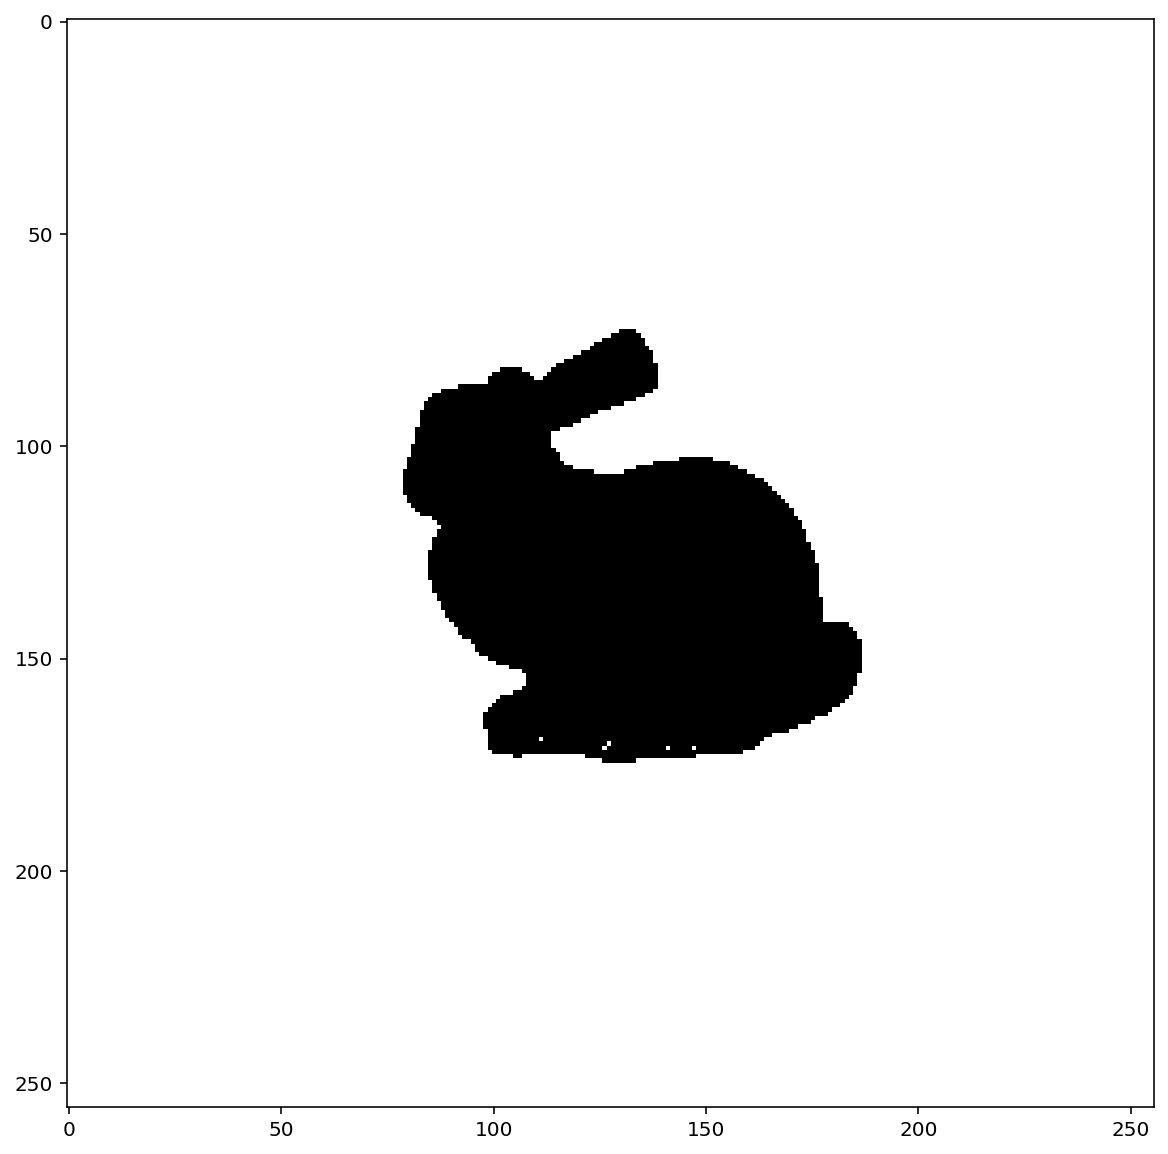

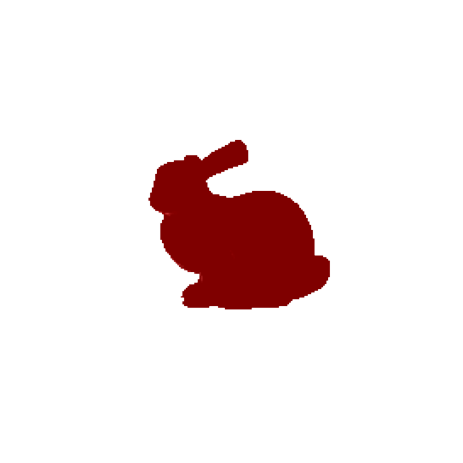

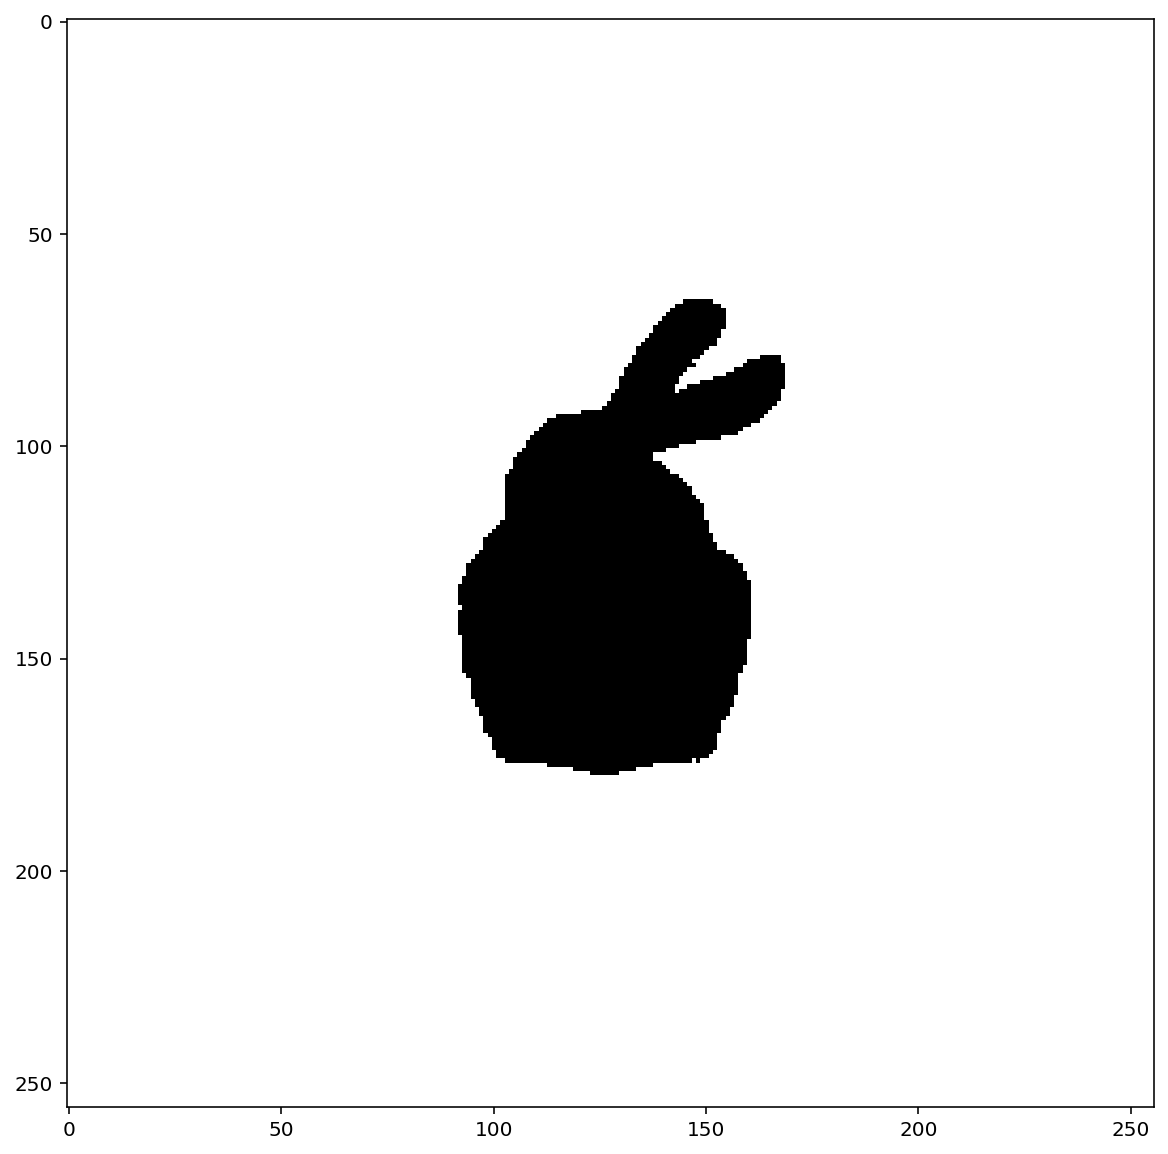

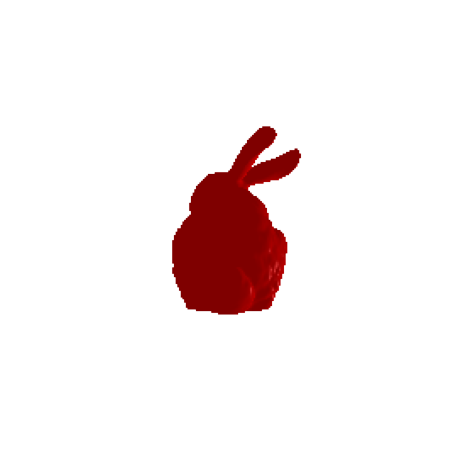

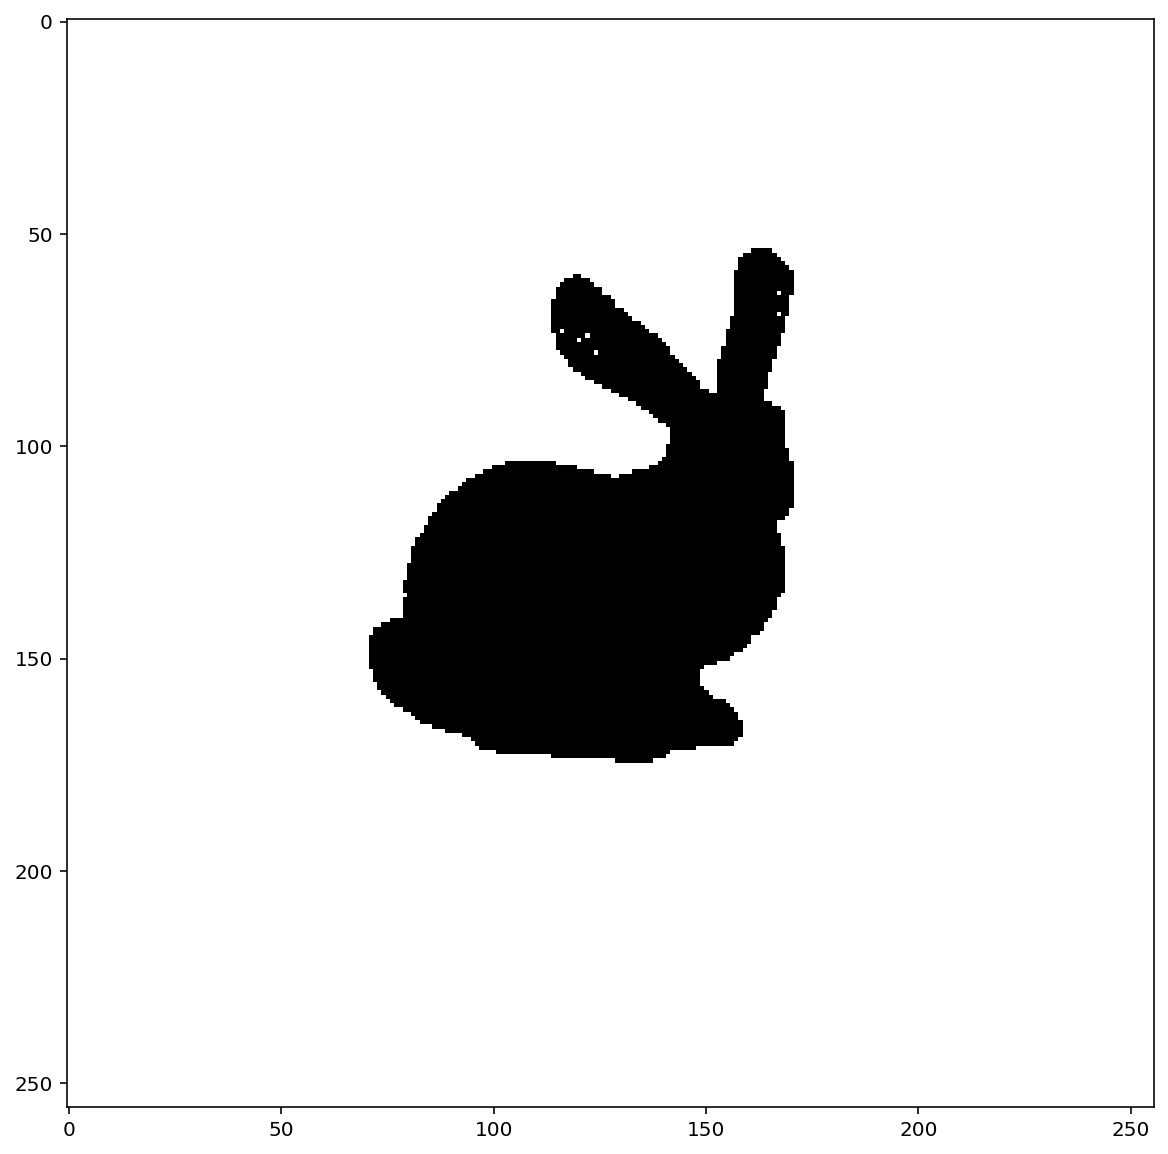

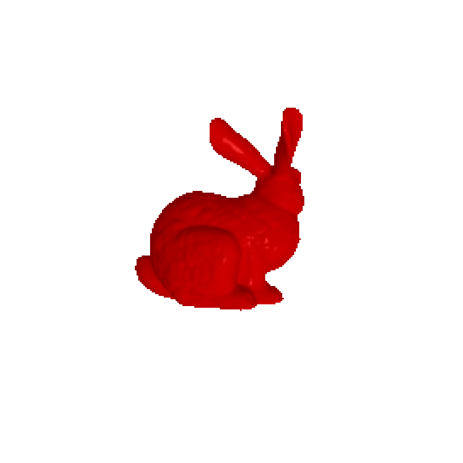

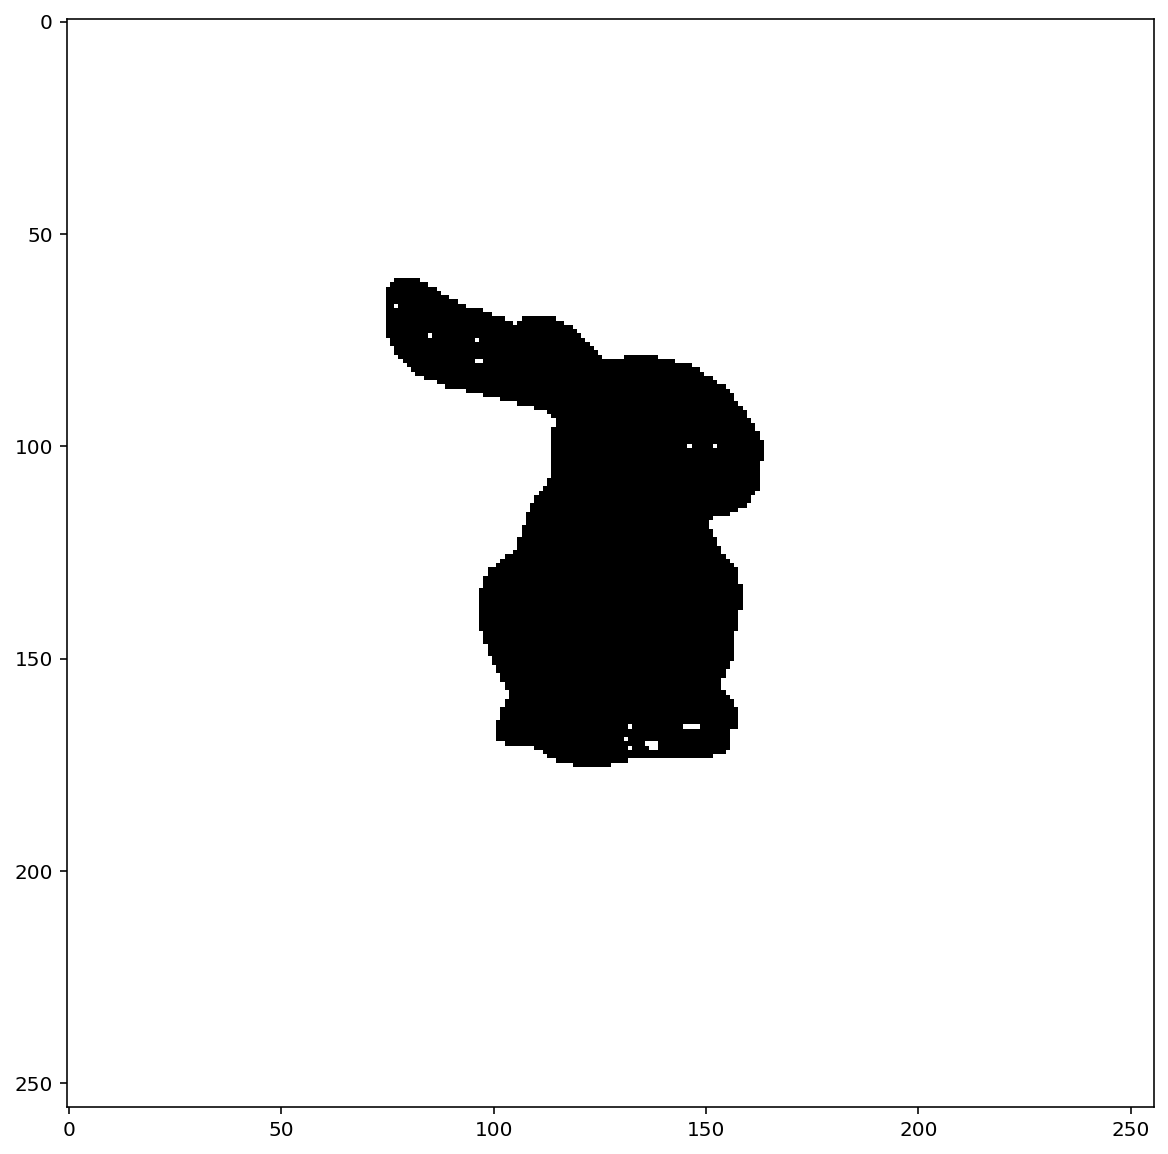

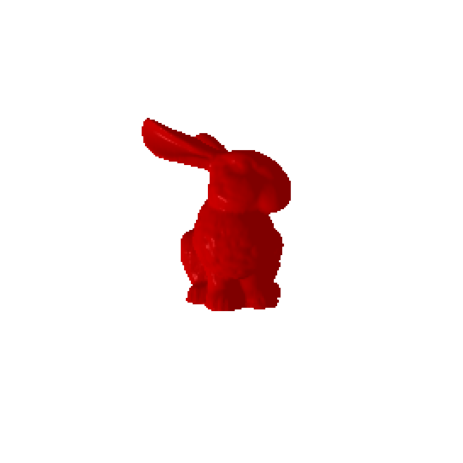

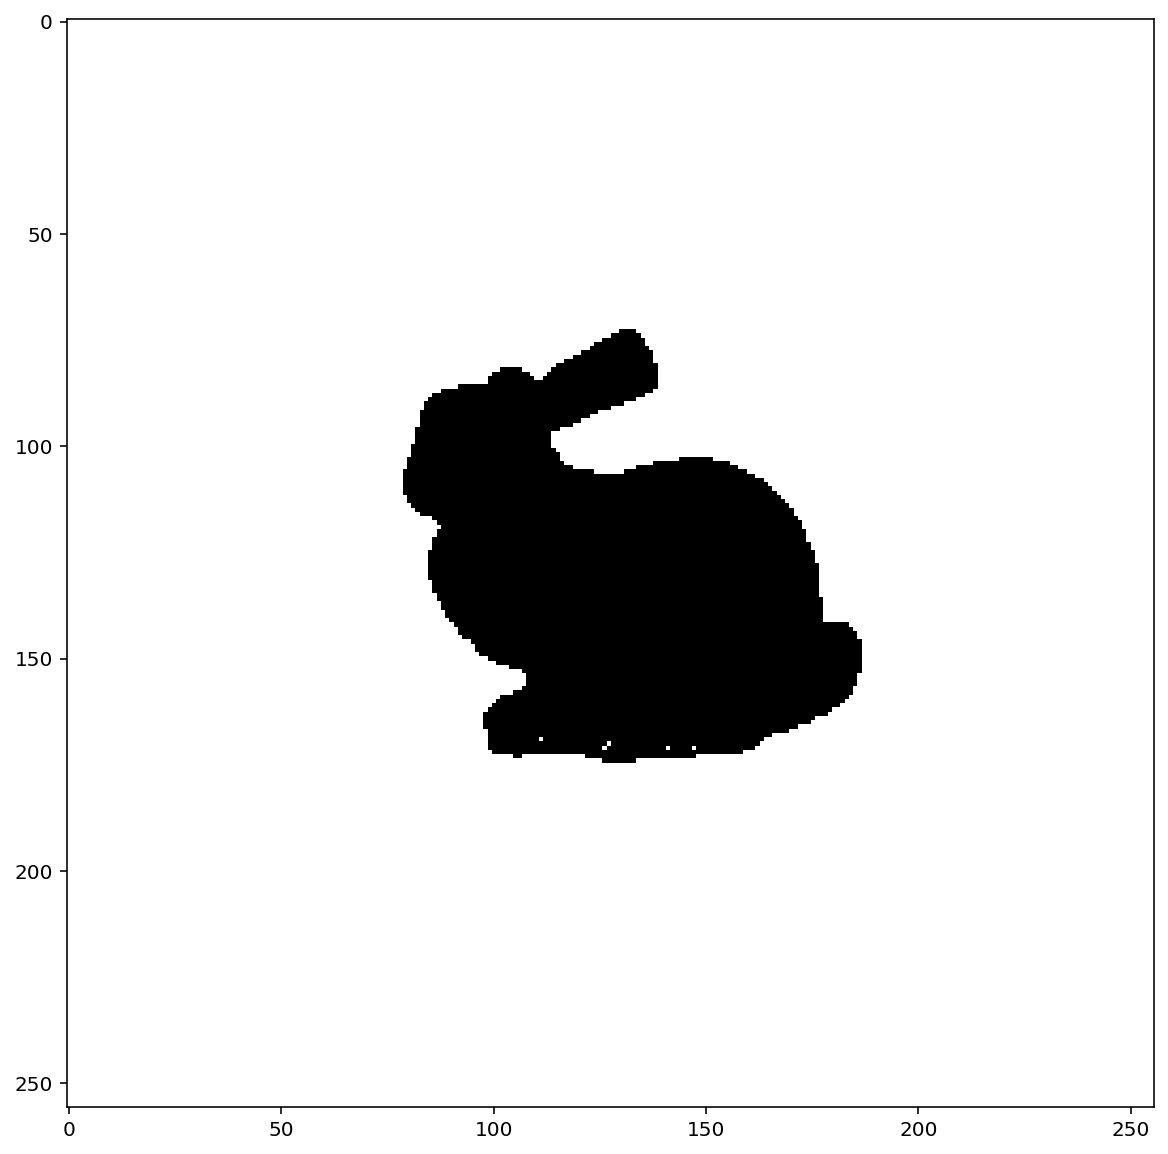

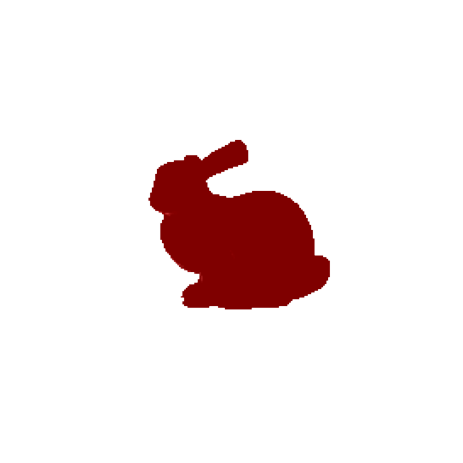

In [ ]:
# for i in [0, 25, 50]:
for i in range(len(images)):
    render_pointcloud(v_hom, cam2world_cv[i:i+1], intrinsics=K_cv[i:i+1],  # modified v_hom.cuda() -> v_hom  # K_cv[:1] -> K_cv[i:i+1]
                      img_resolution=img_resolution)
    plt.imshow(images[i].cpu())
    plt.axis("off");
    plt.show()

As you can tell, the rendering's camera poses and intrinsics are 100% matching. This confirms that we correctly "closed the loop" to go from Pytorch3d to OpenCV and vice-versa.

This process is arduous, but you will have to go through some variant of this every single time you start working with a new 3D computer vision dataset, to make sure that you got all the camera conventions right. 

For Pytorch3D to OpenCV, we just went through the whole process, and, in fact, we will use the little dataset you generated in the next homework!

For other datasets, the process might look slightly different. Say, for instance, you have an RGB-D dataset recorded in the real world with camera poses and intrinsics. Here, you'd only repeat step 1.7 - i.e., you'd try to re-render the RGB-D pointclouds with the converted camera poses and made sure they'd look exactly identical to the images.

# Part 2: Multi-view & epipolar geometry

Now, we will explore some multi-view geometry. Specifically, we will learn how to fuse depth maps from two separate views into a single point cloud. Then, we will learn how to compute epipolar lines across images. 

## 2.0. Rendering a depth map in Pytorch3D

The "depth" of a point is defined as its z coordinate in camera coordinates. A depth map simply plots the z camera coordinate of the 3D point corresponding to each pixel.

We can use Pytorch3D to render out a depth map instead of an RGB image. Other renderes (such as Kubric) have similar functionalities.

In [ ]:
# No need to examine this code closely, unless you're interested!
cam1_idx = 0
cam2_idx = 80

# Pick two of our pytorch3d cameras. (이전 cell 중에서 360도로 돌면서 100개 sampling 했던거.)
mv_cams = cams[[cam1_idx, cam2_idx]]

print(cams[cam1_idx])
print(cams[cam2_idx])

# The rasterizer outputs fragments, each of which stores its own depth
# in the z-buffer.
fragments = rasterizer(mesh.extend(2), cameras=mv_cams)
depths = fragments.zbuf

PerspectiveCameras()
PerspectiveCameras()


We can plot the depth maps using matplotlib.

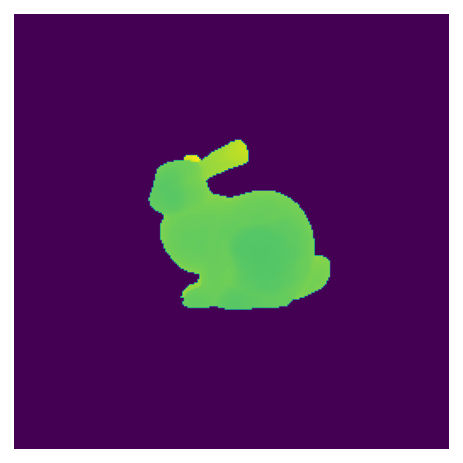

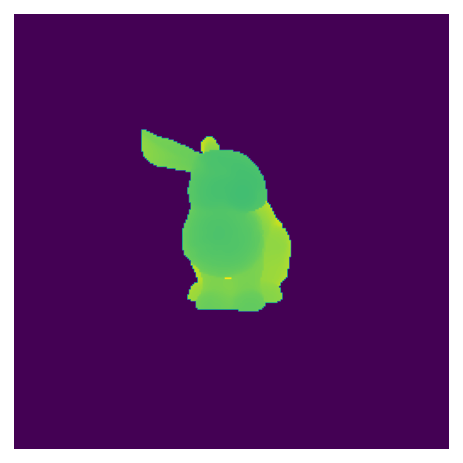

In [ ]:
for depth in depths:
    plt.imshow(depth.cpu().squeeze())
    plt.axis('off')
    plt.show()

We also note the range of the depth maps:

In [ ]:
print(depths.min(), depths.max())

tensor(-1.) tensor(3.7333)


Since $-1$ is not a valid depth value, that tells us that Pytorch3D uses $-1$ to indicate "invalid" depths (i.e., the background in this case). We have to ignore these later.

## 2.1. Fusing Multi-View Depth into a single point cloud

We are now given two camera views with two depth maps respectively. 

Let's fuse them into a single point cloud! 

This is important in its own right, to consolidate multi-view input into a single representation.

However, it's also an important debugging step that allows you to check whether your camera parameters are correct: If you combine two views into a single point cloud, and the point cloud doesn't look right, you have a bug!

### 2.1.1 Writing the "unproject" function

You'll now write a function ```unproject``` that takes x, y pixel coordinates and lifts them to 3D camera coordinates.

Recall the following equation for projecting a 3D coordinate in camera coordinates $\mathbf{X}$ to _homogeneous_ pixel coordinates: (상단식에서는 우항이 3D coor in camera space 이고 좌항이 pixel coord. 하단식에서는 pixel coord -> 3D camera space. K[I|O] 인 이유는 K 는 intrinsic 이고 [I|O] is extrinsic.->이게 아니고 extrinsic은 따로 있고 [I|O]는 (3*4) 맞춰주기 위해서 곱해주는게 맞을듯.  Since we're already in camera space, no need to rotate or translate.) 
$$
\begin{align}
    \begin{pmatrix} 
    f \cdot X + Z \cdot p_x \\ 
    f \cdot Y + Z \cdot p_y\\
    Z 
    \end{pmatrix} &= \mathbf{K} [\mathbf{I} | \mathbf{0} ] 
    \begin{pmatrix}
    X \\
    Y \\
    Z \\
    1
    \end{pmatrix} \\
    \begin{pmatrix} 
    f \cdot X + Z \cdot p_x \\ 
    f \cdot Y + Z \cdot p_y\\
    Z 
    \end{pmatrix} &= \mathbf{K}
    \begin{pmatrix}
    X \\
    Y \\
    Z
    \end{pmatrix} 
\end{align}
$$

Applying the inverse $\mathbf{K}^{-1}$ on both sides, we see:

$$
\begin{align}
    \begin{pmatrix}
    X \\
    Y \\
    Z
    \end{pmatrix} &= \mathbf{K}^{-1} 
    \begin{pmatrix} 
    f \cdot X + Z \cdot p_x \\ 
    f \cdot Y + Z \cdot p_y\\
    Z 
    \end{pmatrix} \\
    \begin{pmatrix}
    X \\
    Y \\
    Z
    \end{pmatrix} &= Z \cdot \mathbf{K}^{-1} 
    \begin{pmatrix} 
    \frac{f \cdot X}{Z} + p_x \\ 
    \frac{f \cdot Y}{Z} + p_y\\
    1 
    \end{pmatrix} \\
    \mathbf{X} &= Z \cdot \mathbf{K}^{-1} 
    \begin{pmatrix} 
    x_{pix} \\ 
    y_{pix} \\
    1
    \end{pmatrix}
\end{align}
$$

This relates 3D world coordinates along a ray to their pixel coordinates and the depth, and is exactly what you have to implement below.

In [ ]:
def unproject(
    xy_pix: torch.Tensor, 
    z: torch.Tensor, 
    intrinsics: torch.Tensor
    ) -> torch.Tensor:
    """Unproject (lift) 2D pixel coordinates xy_pix and per-pixel z coordinate
    to 3D points in camera coordinates.

    Args:
        xy_pix: 2D pixel coordinates of shape (..., 2)
        z: per-pixel depth, defined as z coordinate of shape (..., 1) 
        intrinscis: camera intrinscics of shape (..., 3, 3)

    Returns:
        xyz_cam: points in 3D camera coordinates.
    """
    xy_pix_hom = torch.cat((xy_pix, torch.ones(size=((xy_pix.shape[0], 1)))), dim=-1) # make xy_pix homogeneous system, i.e, add 1 to third column
    
    intrinsics_inv = torch.inverse(intrinsics)
    xyz_cam = z * torch.einsum('bij, bj -> bi', intrinsics_inv, xy_pix_hom)
    return xyz_cam

xy_pix = torch.tensor([[0.5, 0.5]], device=device)
z = depths[:1, img_resolution[0]//2, img_resolution[1]//2]

check_function("unproject",
                unproject,
                [xy_pix, z, K_cv[:1]],
                [torch.tensor([[0.0000, 0.0000, 2.6121]]).to(device)])

unproject : Your function works!


True

A usefule fact: The ray directions in camera space are a special case of this, namely the one where we normalize the unprojected point. For future reference:

In [ ]:
def get_camera_ray_directions(xy_pix:torch.Tensor,
                              intrinsics:torch.Tensor) -> torch.Tensor:
    p = unproject(xy_pix, 
                  torch.ones_like(xy_pix[..., :1], device=device), # shape == N * 1. need N z's.. one for each xy_pix
                  intrinsics=intrinsics)
    return torch.nn.functional.normalize(p, dim=-1)

get_camera_ray_directions(xy_pix, K_cv[:1])

tensor([[0., 0., 1.]])

### 2.1.2 Pixel Coordinates

To lift _every_ pixel in the depth map into a camera-space point cloud, we'll need to generate the right pixel coordinate for each pixel. 

Note that your intrinsics matrix $K$ has to match your pixel coordinates. In particular, the $c_x$ and $c_y$ parameters usually tell you the image center in pixel coordinates - so, if they are, say, $(128, 128)$, then your pixel coordinates should probably go from 0 to 256.

So far, we've been working with *normalized image coordinates* with (0, 0) in the top left and (1, 1) in the bottom right corner, so we'll generate pixel coordinates consistent with that.

In [ ]:
def get_normalized_pixel_coordinates(
    y_resolution: int,
    x_resolution: int,
    device: torch.device = torch.device('cpu')
    ):
    """For an image with y_resolution and x_resolution, return a tensor of pixel coordinates
    normalized to lie in [0, 1], with the origin (0, 0) in the top left corner,
    the x-axis pointing right, the y-axis pointing down, and the bottom right corner
    being at (1, 1).

    Returns:
        xy_pix: a meshgrid of values from [0, 1] of shape 
                (y_resolution, x_resolution, 2)
    """
    y_resolution_norm = torch.linspace(0, 1, steps=(y_resolution), dtype=float)
    x_resolution_norm = torch.linspace(0, 1, steps=(x_resolution), dtype=float)
    xy_pix = []
    # xy_pix = torch.empty(size=(y_resolution, x_resolution,2))
    for y in y_resolution_norm:
      for x in x_resolution_norm:
        xy_pix.append([x,y])
    # print(len(xy_pix))
    xy_pix = torch.tensor(xy_pix).reshape(y_resolution, x_resolution, 2).float()
    # print(xy_pix.shape)
    return xy_pix

xy_pix = get_normalized_pixel_coordinates(img_resolution[0], img_resolution[1])

check_function("get_pixel_coordinates",
               get_normalized_pixel_coordinates,
               [2, 2],
               [torch.tensor([[[0., 0.],
                               [1., 0.]],
                               [[0., 1.],
                               [1., 1.]]])])

get_pixel_coordinates : Your function works!


True

### 2.1.2 Applying our functions

Let's now use these functions to fuse the two depth maps into a single point cloud!

First, we'll convert our `mv_cams` poses from Pytorch3D to OpenCV convention:

In [ ]:
R_w2c_cv, tvec_w2c_cv = pytorch3d_world2cam_to_opencv_world2cam(mv_cams)
K_cv = K_pt3d_to_opencv(mv_cams)

In [ ]:
print(K_cv[0])
print(K_cv[1])

tensor([[0.7000, 0.0000, 0.5000],
        [0.0000, 0.7000, 0.5000],
        [0.0000, 0.0000, 1.0000]])
tensor([[0.7000, 0.0000, 0.5000],
        [0.0000, 0.7000, 0.5000],
        [0.0000, 0.0000, 1.0000]])


We then invert them to get cam2world matrices:

In [ ]:
# Stack into matrices and convert to cam2world
world2cam_cv = torch.eye(4, 4).repeat(2, 1, 1) # 2 because mv_cams has two cameras
world2cam_cv[:, :3, :] = torch.cat((R_w2c_cv, tvec_w2c_cv.unsqueeze(-1)), dim=-1) # "tvec_w2c_cv.unsqueeze(-1))" makes [2,3] -> [2,3,1], i.e, row vector to column vector.
cam2world_cv = world2cam_cv.inverse().to(device)

Next, let's get the pixel coordinates and their corresponding depths.

In [ ]:
# Get pixel coordinates
xy_pix = get_normalized_pixel_coordinates(img_resolution[0], img_resolution[1], device=device) # img_resulution has [y,x] dimension by defualt? # xy_pix is of form that for each y, for each x, has a coor
#dinate. Eg, For y = 0, x = 0 ~ 256, [0,0] ~ [1,0]

print(xy_pix.shape)

# Flatten them
xy_pix = xy_pix.flatten(0, -2) # this is normalized coordinates. only need one while depths has [2, 65536, 2] because two images have different z values for each pixel.

print(xy_pix.shape) 

# Flatten the depth maps
depths = depths.flatten(1, -2)

torch.Size([256, 256, 2])
torch.Size([65536, 2])


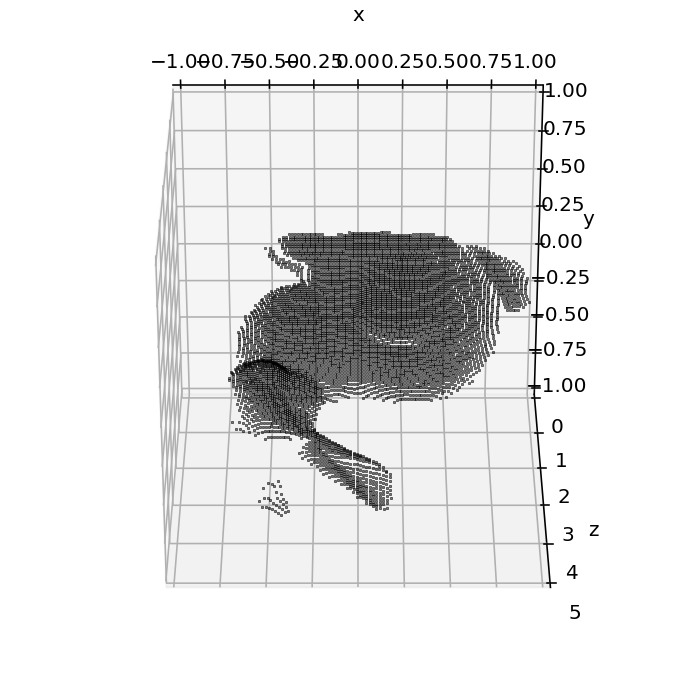

In [ ]:
# Unproject the depth map of camera 1 into a camera-coordinate point cloud.
lifted_cam_1 = unproject(xy_pix, depths[0], intrinsics=K_cv[0:1]) # changed from K_cv[0] -> K_cv[0:1] to keep it 3 dimension, i.e., [1,3,3]. Otherwise, [3,3].

# Filter out the invalid depths (those that are -1).
lifted_cam_1 = lifted_cam_1[depths[0].squeeze()!=-1, :] #lifted_cam_1.shape = (N*3) before squeeze. # Since depths.shape = [2, 65536, 1],  depths[0].squeeze().shape = [65536]. Only size 1 can be squeezed.

plot_pointcloud(lifted_cam_1.cpu(), zlim=(0, 5))

Explanation of the output above: In pytorch3D coord, x left, y up, z away from screen. But plot_pointcloud has elevate:120, which makes camera, which was looking at z direction, now look at -z direction as the output above.

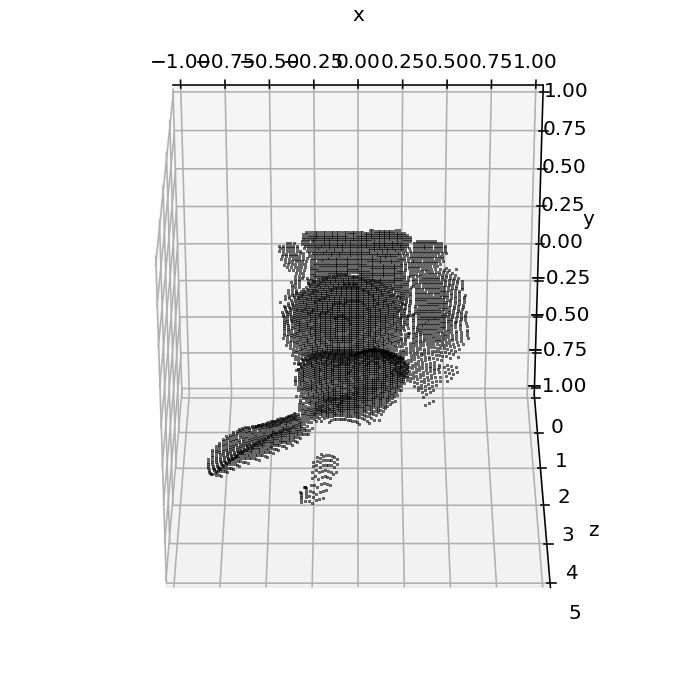

In [ ]:
# Unproject the depth map of camera 2 into a camera-coordinate point cloud.
lifted_cam_2 = unproject(xy_pix, depths[1], intrinsics=K_cv[1:2]) # changed K_cv[0] -> K_cv[1]

# Filter out the invalid depths (those that are -1).
lifted_cam_2 = lifted_cam_2[depths[1].squeeze()!=-1, :]

plot_pointcloud(lifted_cam_2.cpu(), zlim=(0, 5))

Now, we have two point clouds - but they're still in camera coordinates! Below, we transform both of them to world coordinates.

In [ ]:
pc_1_world = transform_cam2world(homogenize_points(lifted_cam_1), cam2world_cv[0:1]) # changed from cam2world_cv[0] -> cam2world_cv[0:1]
pc_2_world = transform_cam2world(homogenize_points(lifted_cam_2), cam2world_cv[1:2]) # changed from cam2world_cv[1] -> cam2world_cv[1:2]

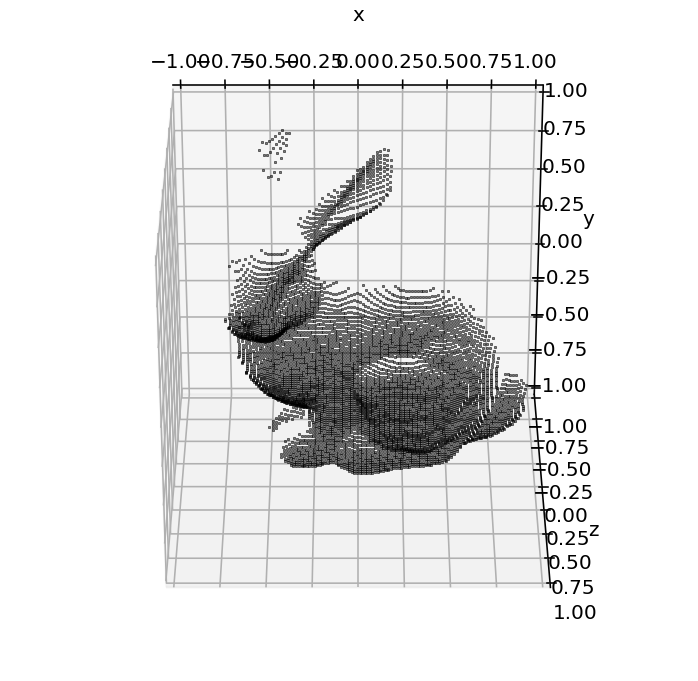

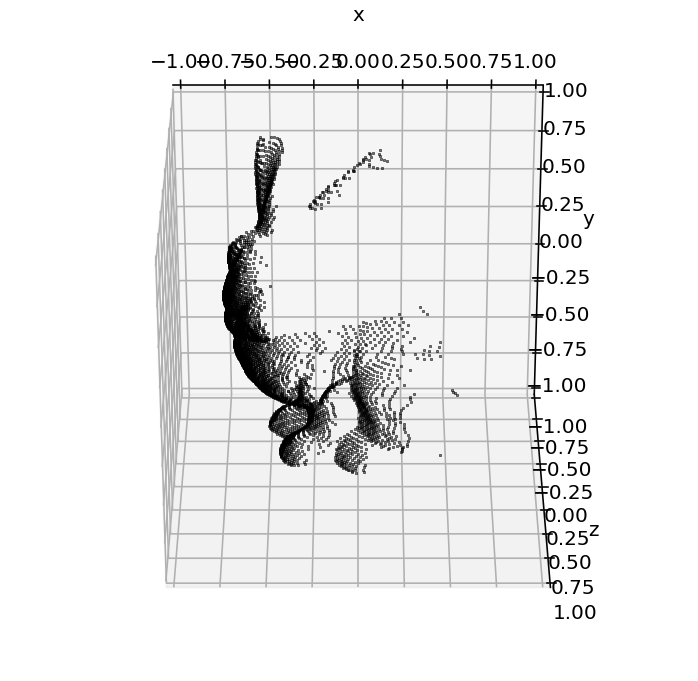

In [ ]:
plot_pointcloud(pc_1_world[..., :3].cpu())
plot_pointcloud(pc_2_world[..., :3].cpu())

It remains to concatenate the tensors and plot the point cloud. If we did it right, the points from the two depth maps should align, and we should clearly see the bunny!

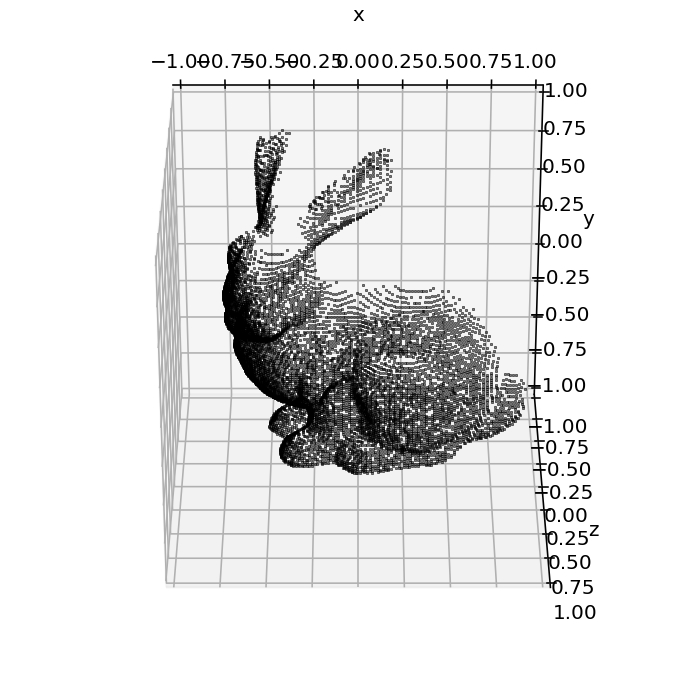

In [ ]:
complete_pc = torch.cat((pc_1_world, pc_2_world), dim=0)
complete_pc = complete_pc.reshape(-1, 4)
plot_pointcloud(complete_pc[..., :3].cpu())

## 2.2 Computing Epipolar Lines



### 2.2.1 Computing the Epipole



In [ ]:
print(points[0])
print(points[80])

tensor([0., 0., 3.])
tensor([-2.8024,  0.0000,  1.0707])


In [ ]:
def get_epipole(cam2world_1: torch.Tensor,
                cam2world_2: torch.Tensor,
                intrinsics_2: torch.Tensor):
    """Computes epipole: camera 1's camera origin projected onto camera 2's image plane.

    Args:
        cam2world_1: cam2world matrix of camera 1 of shape (..., 4, 4)
        cam2world_2: cam2world matrix of camera 2 of shape (..., 4, 4)
        intrinsics_2: camera intrinscics of camera 2 of shape (..., 3, 3)

    Returns:
        epipole: pixel coordinates of camera 1's origin projected onto camera 2's image plane.
    """
    # from all matrices, get vector t to use it as camera origin position in world space
    camera1_world_pos = cam2world_1[:, :3, -1] # (b, 3) # get vector t from cam2world_1

    # make position homogeneous
    camera1_world_pos_hom = torch.cat((camera1_world_pos, torch.ones(size=(camera1_world_pos.shape[0], 1))), dim=-1) # camera1_world_pos_hom.shape = (b,4)
    
    # convert camera1_world_pos_hom in world space to a position in camera2 space
    world2cam_2 = cam2world_2.inverse()# (4,4)
    camera1_pos_in_camera2_space_hom = torch.einsum('bij, bj -> bi', world2cam_2, camera1_world_pos_hom) # camera1_pos_in_camera2_space_hom.shape = (b, 4)
    
    # epipole = torch.einsum('bij, bj -> bi', intrinsics_2, camera1_pos_in_camera2_space_hom[:, :3]) #epipole.shape = (b, 3)  # (b, 3, 3) @ (b, 3)
    intrinsics_2 = torch.cat((intrinsics_2, torch.zeros(size=(intrinsics_2.shape[0], 3, 1))), dim=-1) # (b, 3,4) # make intrisics_2 (3,3) -> (3,4). Adding 0 column. K[I|O]. but not necessary.
    epipole = torch.einsum('bij, bj -> bi', intrinsics_2, camera1_pos_in_camera2_space_hom) # (b, 3,4) @ (b, 4)

    epipole = epipole / epipole[:,-1] # original epiploe is in homogeneous format and need to be (x,y,1). so always need to divide by third element if the third element is not 1.

    return epipole

In [ ]:
epipole = get_epipole(cam2world_cv[:1], cam2world_cv[1:2], K_cv[:1])

check_function("get_epipole",
               get_epipole,
               [cam2world_cv[:1], cam2world_cv[1:2], K_cv[0:1]], #K's in K_cv are all the same because they are just rotating around the bunny at the same f and z.
               [torch.tensor([[1.5168, 0.5000, 1.0000]], device=device)]) # y=0.5 because it's the coord in image plane. not camera view

get_epipole : Your function works!


True


### 2.2.2 Computing the epipolar line

Below, implement the function "get_epipolar_line". There are detailed line-by-line comments that help you along!

In [ ]:
def get_epipolar_line(xy_pix_1: torch.Tensor, 
                      cam2world_1: torch.Tensor,
                      intrinsics_1: torch.Tensor,
                      cam2world_2: torch.Tensor,
                      intrinsics_2: torch.Tensor,
                      ) -> torch.Tensor:
    """Computes epipolar line of ray through pixel xy_pix_1 on the image plane of
    camera 2.

    Args:
        xy_pix_1: camera 1 pixel coordinates that we want to get epipolar lines for. shape(..., 2)
        cam2world_1: cam2world matrix of camera 1 of shape (..., 4, 4)
        intrinsics_1: camera intrinscics of camera 1 of shape (..., 3, 3)
        cam2world_2: cam2world matrix of camera 2 of shape (..., 4, 4)
        intrinsics_2: camera intrinscics of camera 2 of shape (..., 3, 3)

    Returns:
        epipole: pixel coordinates of epipole in camera 2's image plane
        epi_line_dir: the direction of the epipolar line in camera 2's image plane.
        point_2_pix: image coordinate of the second point along the epipolar line 
                    on the image plane of cam2. 
    """
    # get epipole
    epipole = get_epipole(cam2world_1, cam2world_2, intrinsics_2)

    ##### get point_2_pix #####
    # since intrinsics_1 is camera -> image, I want image -> camera.
    intrinsics_1_inv = intrinsics_1.inverse()
    # homegeneous of xy_pix_1
    xy_pix_1_hom = torch.cat((xy_pix_1, torch.ones(size=(xy_pix_1.shape[0], 1))), dim = -1) # xy_pix_1_hom.shape = (b, 3)
    # send xy_pix_1 from image/pixel coor -> camera coord
    xy_pix_1_hom_camera_space = torch.einsum('bij, bj -> bi', intrinsics_1_inv, xy_pix_1_hom) # xy_pix_1_hom_camera_space.shape = (b, 3)
    # homogenous of xy_pix_1_hom_camera_space
    xy_pix_1_hom_camera_space_hom = torch.cat((xy_pix_1_hom_camera_space, torch.ones(size=(xy_pix_1_hom_camera_space.shape[0], 1))), dim = -1) # xy_pix_1_hom_camera_space_hom.shape = (b, 4)
    # send xy_pix_1_hom_camera_space_hom from camera to world
    xy_pix_1_hom_world_space_hom = torch.einsum('bij, bj -> bi', cam2world_1, xy_pix_1_hom_camera_space_hom) # xy_pix_1_hom_world_space_hom.shape = (b ,4)
    # send xy_pix_1_hom_world_space_hom from world to camera2's space
    xy_pix_1_in_camera_2_hom = torch.einsum('bij, bj -> bi', cam2world_2.inverse(), xy_pix_1_hom_world_space_hom) # xy_pix_1_in_camera_2_hom.shape = (b,4)
    # add 0 column to intrinsics_2
    intrinsics_2 = torch.cat((intrinsics_2, torch.zeros(size=(intrinsics_2.shape[0], 3, 1))), dim=-1) # result intrinsics_2.shpae = (b, 3, 4)
    # send xy_pix_1_in_camera_2_hom from camera2 to caera2's image plane
    xy_pix_2_in_camera_2_image_hom = torch.einsum('bij, bj -> bi', intrinsics_2, xy_pix_1_in_camera_2_hom) # xy_pix_2_in_camera_2_image_hom.shape = (b, 3)
    # divide by w
    xy_pix_2_in_camera_2_image_hom = xy_pix_2_in_camera_2_image_hom / xy_pix_2_in_camera_2_image_hom[:,-1]
    point_2_pix = xy_pix_2_in_camera_2_image_hom
    ##### get point_2_pix #####

    # get epi_line_dir
    epi_line_dir = point_2_pix - epipole
    
    return epipole, epi_line_dir, point_2_pix

In [ ]:
check_function("get_epipolar_line",
               get_epipolar_line,
               [torch.tensor([[0.5, 0.5]], device=device), cam2world_cv[:1], K_cv[:1], cam2world_cv[1:2], K_cv[:1]],
               [torch.tensor([[1.5168, 0.5000, 1.0000]], device=device), 
                torch.tensor([[-0.4447,  0.0000,  0.0000]], device=device),
                torch.tensor([[1.0720, 0.5000, 1.0000]], device=device)])

get_epipolar_line : Your function works!


True

Let's test if it's working! We'll pick a point in camera 1, and visualize the its epipolar line in camera 2. Let's plot the RGB images corresponding to the two depth maps:

My note: I used points[80] only. so images[cam1_idx] where cam1_idx = 0 will show images[80] not images[0]. Rerun points cell to correct the image.

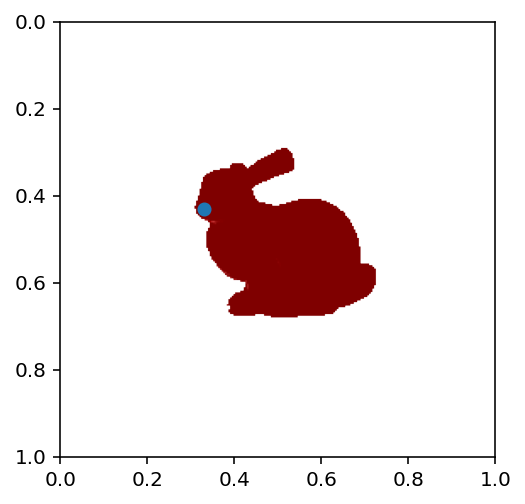

In [ ]:
pix_coords = torch.tensor([[0.33, 0.43]], device=device)

# Image 1
plt.imshow(images[cam1_idx].cpu(), extent=[0., 1., 1., 0.])
plt.scatter(pix_coords[0, :1].cpu(), pix_coords[0, 1:].cpu())
plt.show()

Let's pick a point at the nose of the bunny, i.e., at [0.33, 0.43].

---



In [ ]:
epipole, epi_line_dir, point_2_pix = get_epipolar_line(pix_coords, cam2world_cv[:1], K_cv[:1], cam2world_cv[1:2], K_cv[:1])

In [ ]:
epi_line_points = epipole + torch.linspace(0, 3, 1000, device=device)[:, None] * epi_line_dir
print(epi_line_points.shape)

torch.Size([1000, 3])


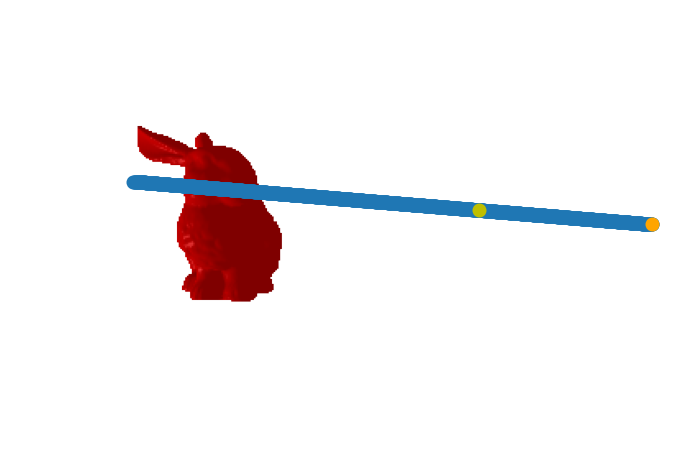

In [ ]:
# Image 2
# plt.imshow(images[cam2_idx].cpu(), extent=[0., 1., 1., 0.])
plt.imshow(images[1].cpu(), extent=[0., 1., 1., 0.])
plt.scatter(epi_line_points[:, :1].cpu(), epi_line_points[:, 1:2].cpu())
plt.scatter(epipole[:, :1].cpu(), epipole[:, 1:2].cpu(), color="orange")
plt.scatter(point_2_pix[:, :1].cpu(), point_2_pix[:, 1:2].cpu(), color="y")
plt.axis('off')
plt.show()